# Wage Prediction Model for JP Morgan
* Authors: Jihoon Chung, Kibae Kim

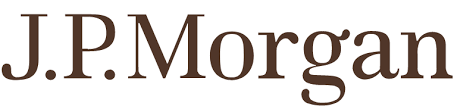

## Overview

Using the customized data pulled out from CPS.IMPUMS.ORG, we retrieved various demographics data such as housing status, state, age, sex, race, marital status, veteran status, number of child, education level, occupation, industry of occupation, disabillity status, and health insurance status. Using these variables, our goal is to build up a machine learning model that can successfully predict whether a person's salary will be higher than $1M or not.

## Business Problem

Our client, JP Morgan Chase, is trying to attract more wealthy investors for their newly improvised cryptocurrency fund. JP Morgan gave us access to their demographics survey data which performed against general public. Although survey data seems to have very little relationship to the income of a personnel, we would have to build an accurate model to filter out individuals making salary higher than $1M so JP Morgan can appropriately send out invitations to join their cryptocurrency fund.

## Data Understanding

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

from sklearn.utils import resample
from sklearn.datasets import load_breast_cancer, load_iris, make_classification
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import MissingIndicator, SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,\
    precision_score, recall_score, accuracy_score, f1_score, log_loss,\
    roc_curve, roc_auc_score, classification_report, plot_roc_curve, auc, precision_recall_fscore_support
from sklearn.feature_selection import SelectFromModel
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

## import cartopy features
import geopandas as gpd
import geoplot as gplt
%matplotlib inline
#pip install geopandas
#pip install geoplot

### Current Population Survey Databases

We used data of Current Population Survey from IPUMS CPS (https://cps.ipums.org/cps-action/variables/group)

In [2]:
#loading the data as a pandas dataframe
df = pd.read_csv("./data/income data from IPUMS.csv")

In [3]:
# Check out our data
df.head()

,YEAR,HHTENURE,STATEFIP,AGE,SEX,RACE,MARST,VETSTAT,NCHILD,EDUC,OCCLY,INDLY,INCWAGE,DISABWRK,PHIOWN
0,2011,1.0,23,55,1,100,6,1,0,73,0.0,0.0,0.0,2.0,2.0
1,2011,1.0,23,74,2,100,1,1,0,81,0.0,0.0,0.0,1.0,2.0
2,2011,1.0,23,75,1,100,1,1,0,50,0.0,0.0,0.0,1.0,2.0
3,2011,1.0,23,48,1,100,1,1,0,73,220.0,770.0,30000.0,1.0,2.0
4,2011,1.0,23,41,2,100,1,1,0,81,430.0,9090.0,0.0,1.0,2.0


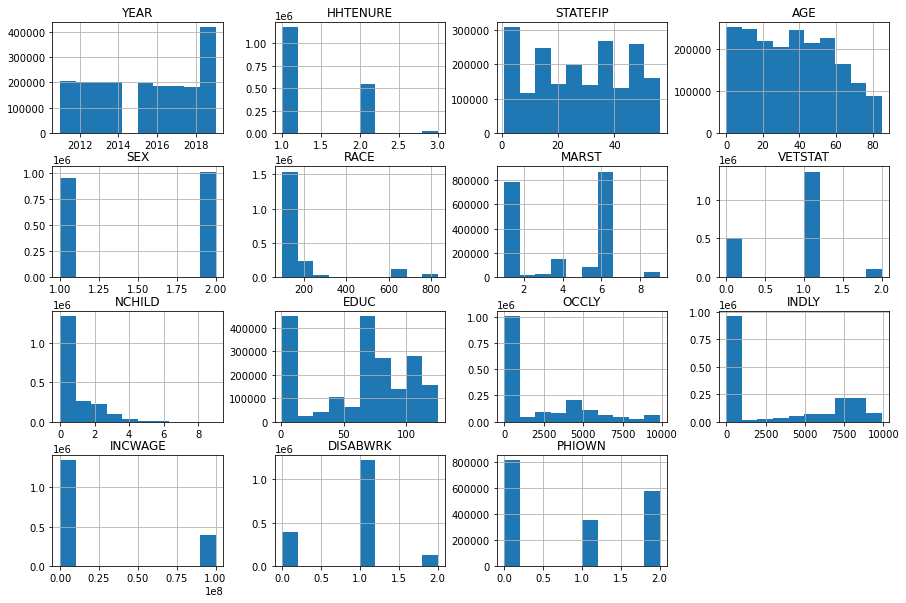

In [4]:
fig, ax = plt.subplots(figsize = (15,10))
df.hist(bins = 10, ax=ax)
fig.savefig('./images/variables_distribution.png');

Using the histograms, we can have general sense of idea on distribution of each class. We can see most of the data distribution is quite imbalanced which we would have to deal with later on.

In [5]:
# taking a look at the file
df.head()

,YEAR,HHTENURE,STATEFIP,AGE,SEX,RACE,MARST,VETSTAT,NCHILD,EDUC,OCCLY,INDLY,INCWAGE,DISABWRK,PHIOWN
0,2011,1.0,23,55,1,100,6,1,0,73,0.0,0.0,0.0,2.0,2.0
1,2011,1.0,23,74,2,100,1,1,0,81,0.0,0.0,0.0,1.0,2.0
2,2011,1.0,23,75,1,100,1,1,0,50,0.0,0.0,0.0,1.0,2.0
3,2011,1.0,23,48,1,100,1,1,0,73,220.0,770.0,30000.0,1.0,2.0
4,2011,1.0,23,41,2,100,1,1,0,81,430.0,9090.0,0.0,1.0,2.0


## Data Preparation

### Data Cleaning

To clean data, we first checked optimum values of income from wage variable.

In [6]:
# concentrate income within $300,000 to $1M
df2 = df[(df.INCWAGE >= 300000) & (df.INCWAGE <= 10000000)] 
df2 = df2[(df2.RACE < 700)]
df2 = df2[(df2.MARST < 9)]

We can tell that our wage distribution is highly imbalanced, and most of the income is populated within $200k ~ $400K area.

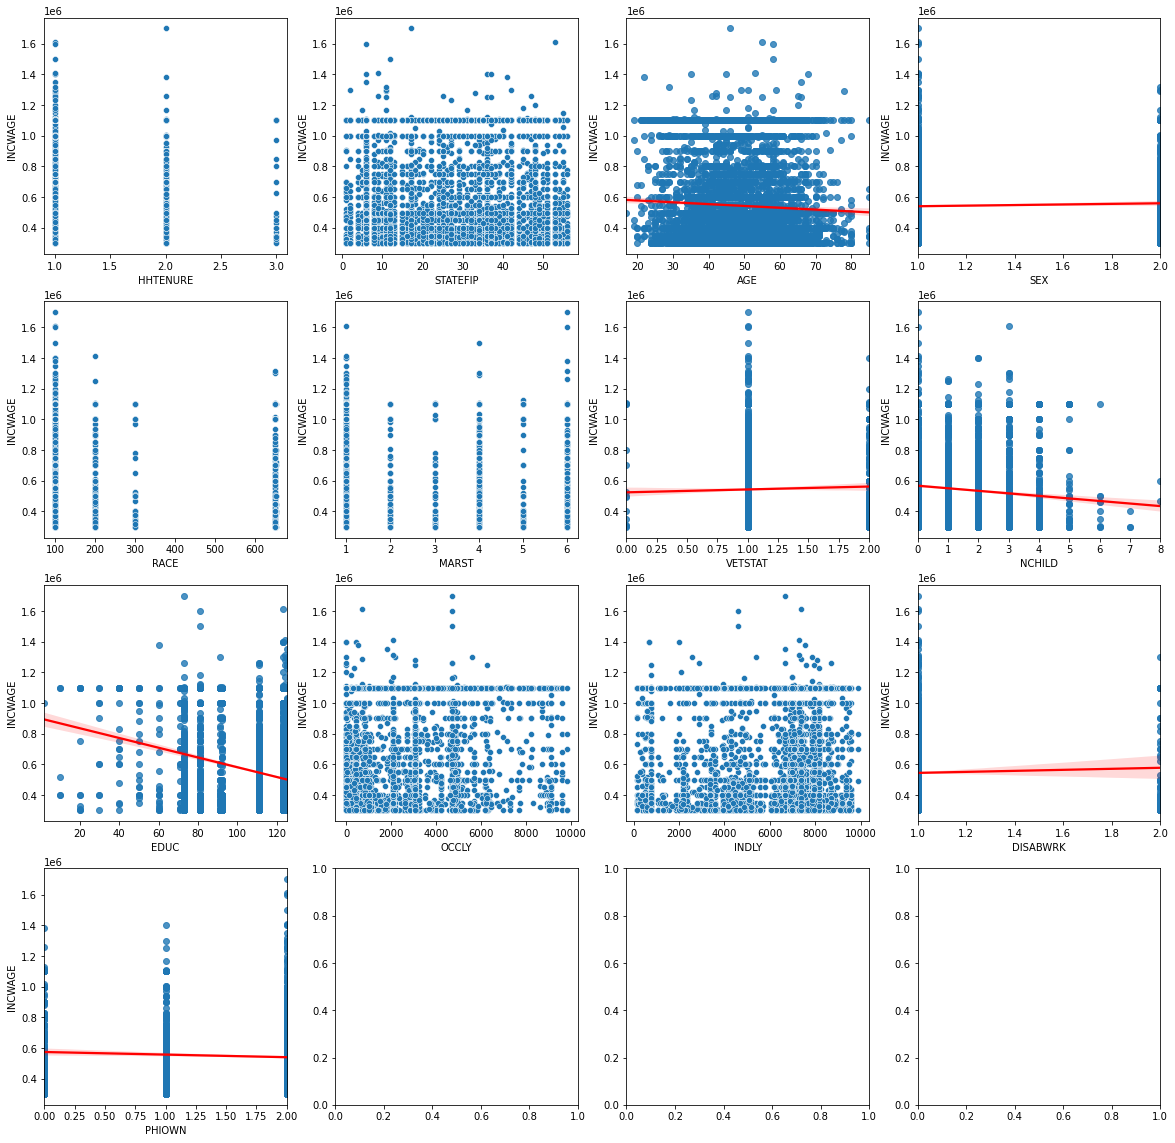

In [7]:
# create regression plots to check the relationship between price and other variables
fig, axes = plt.subplots(4, 4, figsize=(20,20))
ax1 = axes[0][0]
ax2 = axes[0][1]
ax3 = axes[0][2]
ax4 = axes[0][3]
ax5 = axes[1][0]
ax6 = axes[1][1]
ax7 = axes[1][2]
ax8 = axes[1][3]
ax9 = axes[2][0]
ax10 = axes[2][1]
ax11 = axes[2][2]
ax12 = axes[2][3]
ax13 = axes[3][0]
X = df2.drop('INCWAGE', axis = 1)
y = df2['INCWAGE']
sns.scatterplot(x=X['HHTENURE'], y=y, ax=ax1)
sns.scatterplot(x=X['STATEFIP'], y=y, ax=ax2)
sns.regplot(x=X['AGE'], y=y, line_kws={"color": "red"}, ax=ax3)
sns.regplot(x=X['SEX'], y=y, line_kws={"color": "red"}, ax=ax4)
sns.scatterplot(x=X['RACE'], y=y, ax=ax5)
sns.scatterplot(x=X['MARST'], y=y, ax=ax6)
sns.regplot(x=X['VETSTAT'], y=y, line_kws={"color": "red"}, ax=ax7)
sns.regplot(x=X['NCHILD'], y=y, line_kws={"color": "red"}, ax=ax8)
sns.regplot(x=X['EDUC'], y=y, line_kws={"color": "red"}, ax=ax9)
sns.scatterplot(x=X['OCCLY'], y=y, ax=ax10)
sns.scatterplot(x=X['INDLY'], y=y, ax=ax11)
sns.regplot(x=X['DISABWRK'], y=y, line_kws={"color": "red"}, ax=ax12)
sns.regplot(x=X['PHIOWN'], y=y, line_kws={"color": "red"}, ax=ax13)
fig.savefig('./images/wage_variables_relationship.png')

From the regplot, we found out some interesting facts such as:
1. general income decreases as age increases.
2. general income decreases as education level increases. <br>
---
Other than that, we can see that there is not much of a profound relationship between for each varaible vs. income.

## Feature Engineering

### Occupation

we made 4 clasifications occupation baed on mean income of each occupation.
1. low = 0~25% of 
2. middle = 25%~75%
3. high = 75%~1 million
4. Very high = Above 1 million

In [8]:
# Review mean of yearly wage per occupation.
mean_inc = df2.groupby('OCCLY')['INCWAGE'].agg(['mean']).reset_index()
mean_inc = mean_inc.sort_values(['mean'],ascending=True)
mean_inc.head()

,OCCLY,mean
130,3256.0,300000.0
200,5160.0,300000.0
42,860.0,300000.0
232,6320.0,300000.0
142,3540.0,300000.0


In [9]:
mean_inc.describe()

,OCCLY,mean
count,310.000000,3.100000e+02
mean,4204.012903,6.742452e+05
std,2811.040749,2.433779e+05
min,10.000000,3.000000e+05
25%,1705.000000,4.733833e+05
50%,3935.000000,6.341665e+05
75%,6305.000000,8.420399e+05
max,9840.000000,1.123287e+06


In [10]:
# Classify Occuptaion per wage.
bins = [0, 4.684705e+05, 8.403965e+05, 1.0e+06, 1.123287e+06]
labels = ['low', 'middle', 'high', 'very_high']
mean_inc['Job_class'] = pd.cut(mean_inc['mean'], bins=bins, labels=labels)
mean_inc

,OCCLY,mean,Job_class
130,3256.0,300000.0,low
200,5160.0,300000.0,low
42,860.0,300000.0,low
232,6320.0,300000.0,low
142,3540.0,300000.0,low
...,...,...,...
228,6220.0,1099999.0,very_high
131,3258.0,1100199.0,very_high
251,7200.0,1103499.0,very_high
248,7120.0,1106999.0,very_high


In [11]:
# Stroe occupations' wage class into list for future reference.
low = []
middle = []
high = []
very_high  = []

for i in range(len(mean_inc)):
    if mean_inc.Job_class[i] == 'low':
        low.append(mean_inc.OCCLY[i])
    elif mean_inc.Job_class[i] == 'middle':
        middle.append(mean_inc.OCCLY[i])
    elif mean_inc.Job_class[i] == 'high':
        high.append(mean_inc.OCCLY[i])
    else:
        very_high.append(mean_inc.OCCLY[i])

In [12]:
# Transform data into dictionary for mapping prepartion
mean_inc2 = mean_inc.set_index('OCCLY').to_dict('dict')

In [13]:
# Transform Occuptional Data into main dataframe.
df2['job_class'] = df2.OCCLY.map(mean_inc2['Job_class'])

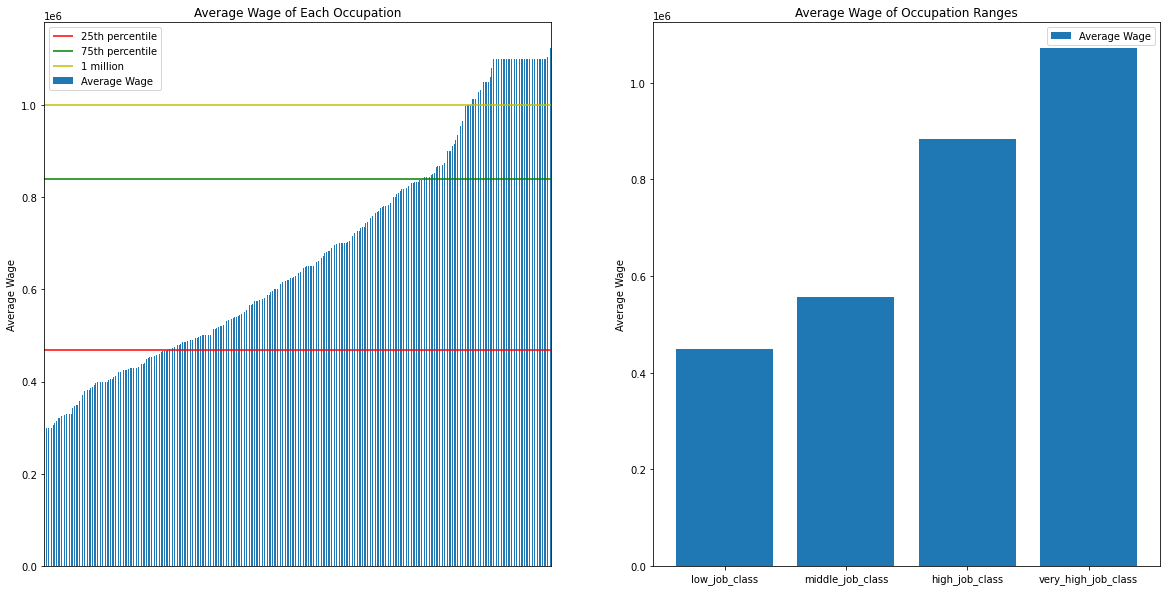

In [14]:
# make plot to show Average wage of occupation variable
percent_25 = 4.684705e+05
percent_75 = 8.403965e+05
one_mil = 1.0e+06

low_job_class = df2[df2.job_class == 'low'].INCWAGE.mean()
middle_job_class = df2[df2.job_class == 'middle'].INCWAGE.mean()
high_job_class = df2[df2.job_class == 'high'].INCWAGE.mean()
very_high_job_class = df2[df2.job_class == 'very_high'].INCWAGE.mean()

x2 = ['low_job_class', 'middle_job_class', 'high_job_class', 'very_high_job_class']
y2 = [low_job_class, middle_job_class, high_job_class, very_high_job_class]

fig, axes = plt.subplots(1,2, figsize=(20,10))

mean_inc.plot.bar('OCCLY', 'mean', ax=axes[0], label="Average Wage")
axes[0].hlines(y=percent_25,xmin=-0.5, xmax=800, color='r', linestyle='-', label="25th percentile")
axes[0].hlines(y=percent_75,xmin=-0.5, xmax=800, color='g', linestyle='-', label="75th percentile")
axes[0].hlines(y=one_mil,xmin=-0.5, xmax=800, color='y', linestyle='-', label="1 million")
axes[0].axes.xaxis.set_visible(False)
axes[0].set_title('Average Wage of Each Occupation')
axes[0].set_ylabel('Average Wage')
axes[0].legend()


axes[1].bar(x2, y2, label="Average Wage")
axes[1].set_title('Average Wage of Occupation Ranges')
axes[1].set_ylabel('Average Wage')
axes[1].legend()

fig.savefig('./images/average_wage_occupation.png')

In [15]:
# Set dummy variables
df2 = pd.get_dummies(df2,prefix=['job_class'], drop_first=True)

### Industry

we made 4 clasifications occupation baed on mean income of each industry.
1. low = 0~25% of 
2. middle = 25%~75%
3. high = 75%~1 million
4. Very high = Above 1 million

In [16]:
# Review mean of yearly wage per industry.
industry_class = df2.groupby('INDLY')['INCWAGE'].agg('mean').reset_index()
industry_class = industry_class.sort_values(['INCWAGE'],ascending=True)
industry_class.head()

,INDLY,INCWAGE
74,3770.0,300000.0
41,2470.0,300000.0
15,1070.0,300000.0
49,2770.0,300000.0
161,6780.0,300000.0


In [17]:
industry_class.describe()

,INDLY,INCWAGE
count,237.000000,2.370000e+02
mean,5165.561181,5.828927e+05
std,2614.852299,1.741523e+05
min,170.000000,3.000000e+05
25%,3095.000000,4.783333e+05
50%,5080.000000,5.501110e+05
75%,7460.000000,6.871427e+05
max,9890.000000,1.159999e+06


In [18]:
# Set Bins and Labels
industry_bins = [0, 4.783333e+05, 6.871427e+05, 1e+06, 1.159999e+06]
industry_labels = ['low', 'middle', 'high', 'very_high']
industry_class['industry_class'] = pd.cut(industry_class['INCWAGE'], bins=industry_bins, labels=industry_labels)

In [19]:
# Transform data into dictionary for mapping prepartion
industry_class_INDLY = industry_class.drop(columns=['INCWAGE'])
industry_class_INDLY = industry_class.set_index('INDLY').to_dict('dict')

In [20]:
# Transform State Data into main dataframe.
df2['industry_class'] = df2.INDLY.map(industry_class_INDLY['industry_class'])

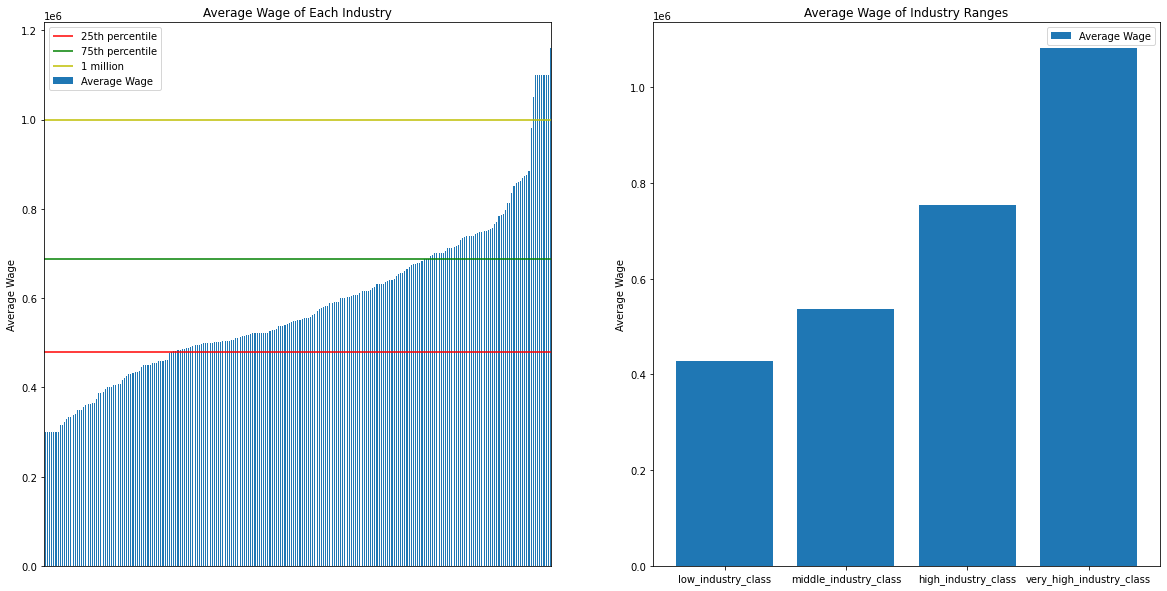

In [21]:
# make plot to show Average wage of industry variable
percent_25 = 4.783333e+05
percent_75 = 6.871427e+05
one_mil = 1.0e+06


low_industry_class = df2[df2.industry_class == 'low'].INCWAGE.mean()
middle_industry_class = df2[df2.industry_class == 'middle'].INCWAGE.mean()
high_industry_class = df2[df2.industry_class == 'high'].INCWAGE.mean()
very_high_industry_class = df2[df2.industry_class == 'very_high'].INCWAGE.mean()

x2 = ['low_industry_class', 'middle_industry_class', 'high_industry_class', 'very_high_industry_class']
y2 = [low_industry_class, middle_industry_class, high_industry_class, very_high_industry_class]

fig, axes = plt.subplots(1,2, figsize=(20,10))

industry_class.plot.bar('INDLY', 'INCWAGE', ax=axes[0], label="Average Wage")
axes[0].hlines(y=percent_25,xmin=-0.5, xmax=900, color='r', linestyle='-', label="25th percentile")
axes[0].hlines(y=percent_75,xmin=-0.5, xmax=900, color='g', linestyle='-', label="75th percentile")
axes[0].hlines(y=one_mil,xmin=-0.5, xmax=900, color='y', linestyle='-', label="1 million")
axes[0].axes.xaxis.set_visible(False)
axes[0].set_title('Average Wage of Each Industry')
axes[0].set_ylabel('Average Wage')
axes[0].legend()


axes[1].bar(x2, y2, label="Average Wage")
axes[1].set_title('Average Wage of Industry Ranges')
axes[1].set_ylabel('Average Wage')
axes[1].legend()
fig.savefig('./images/average_wage_industry.png')

In [22]:
# Set dummy variables
df2 = pd.get_dummies(df2,prefix=['industry_class'], drop_first=True)

### State

we made 3 clasifications occupation baed on mean income of each State.
1. low = 0~25% of 
2. middle = 25%~75%
3. high = Over 75%

In [23]:
# Review mean of yearly wage per state.
state_class = df2.groupby('STATEFIP')['INCWAGE'].agg('mean').reset_index()
state_class = state_class.sort_values(['INCWAGE'],ascending=True)
state_class.head()

,STATEFIP,INCWAGE
19,23,449976.651163
50,56,468885.760870
39,44,490043.405797
46,51,492820.593103
21,25,496221.511364


In [24]:
state_class.describe()

,STATEFIP,INCWAGE
count,51.000000,51.000000
mean,28.960784,551390.296574
std,15.832828,49668.490765
min,1.000000,449976.651163
25%,16.500000,522897.606989
50%,29.000000,549442.192308
75%,41.500000,575923.271071
max,56.000000,776548.906667


In [25]:
# Set Bins and Labels
state_bins = [0, 522897.606989, 575923.271071, 776548.906667]
state_labels = ['low', 'middle', 'high']
state_class['state_class'] = pd.cut(state_class['INCWAGE'], bins=state_bins, labels=state_labels)

In [26]:
# Transform data into dictionary for mapping prepartion
state_class_STATE = state_class.drop(columns=['INCWAGE'])
state_class_STATE = state_class.set_index('STATEFIP').to_dict('dict')

In [27]:
# Transform State Data into main dataframe.
df2['state_class'] = df2.STATEFIP.map(state_class_STATE['state_class'])

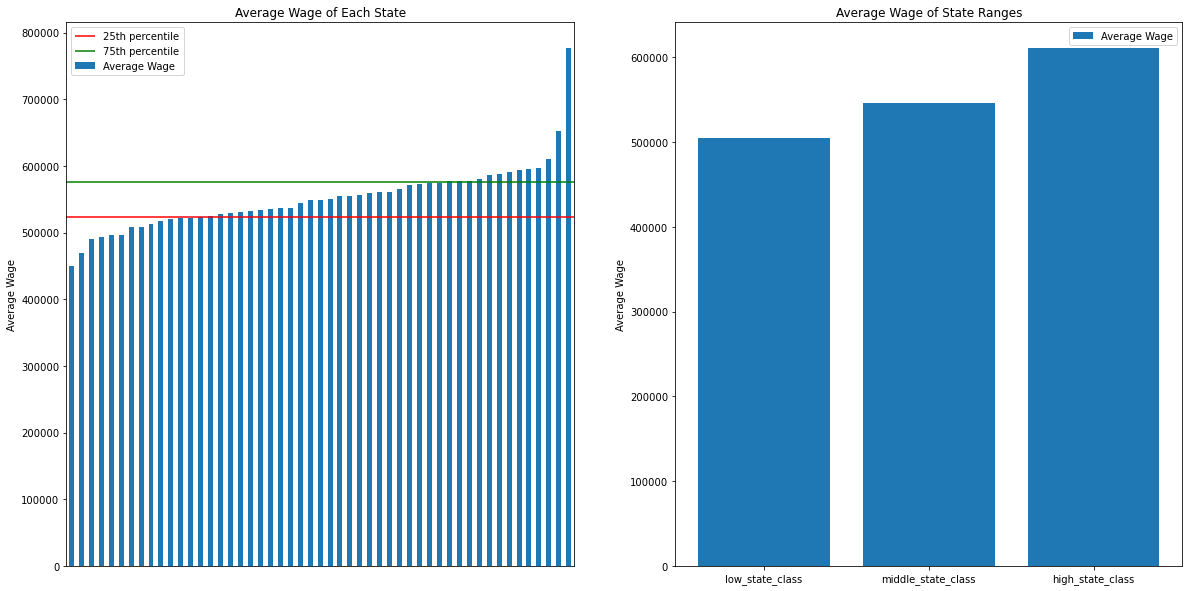

In [28]:
# make plot to show Average wage of state variable
percent_25 = 522897.606989
percent_75 = 575923.271071


low_state_class = df2[df2.state_class == 'low'].INCWAGE.mean()
middle_state_class = df2[df2.state_class == 'middle'].INCWAGE.mean()
high_state_class = df2[df2.state_class == 'high'].INCWAGE.mean()

x2 = ['low_state_class', 'middle_state_class', 'high_state_class']
y2 = [low_state_class, middle_state_class, high_state_class]

fig, axes = plt.subplots(1,2, figsize=(20,10))

state_class.plot.bar('STATEFIP', 'INCWAGE', ax=axes[0], label="Average Wage")
axes[0].hlines(y=percent_25,xmin=-0.5, xmax=800, color='r', linestyle='-', label="25th percentile")
axes[0].hlines(y=percent_75,xmin=-0.5, xmax=800, color='g', linestyle='-', label="75th percentile")
axes[0].axes.xaxis.set_visible(False)
axes[0].set_title('Average Wage of Each State')
axes[0].set_ylabel('Average Wage')
axes[0].legend()


axes[1].bar(x2, y2, label="Average Wage")
axes[1].set_title('Average Wage of State Ranges')
axes[1].set_ylabel('Average Wage')
axes[1].legend()
fig.savefig('./images/average_wage_state.png')

Now, let's visualize average income per state.

In [29]:
# Read state codes data
state_code = pd.read_csv('./data/state_codes.csv')

In [30]:
# Turn the data into dictionary
state_code_dict = state_code.set_index('STATEFIP').to_dict('dict')

In [31]:
state_names = state_class

In [32]:
# Map State codes into State Names

state_names['STATE'] = state_names.STATEFIP.map(state_code_dict['State'])
state_names.drop(['STATEFIP', 'state_class'], axis=1, inplace=True)
state_names = state_names.reindex(columns=['STATE','INCWAGE'])

In [33]:
state_names.head()

,STATE,INCWAGE
19,Maine,449976.651163
50,Wyoming,468885.760870
39,Rhode Island,490043.405797
46,Virginia,492820.593103
21,Massachusetts,496221.511364


In [34]:
#Change state names to upper case.
state_names['STATE'] = state_names['STATE'].str.upper()

In [35]:
# Read State geometry shape file for mapping purpose
state_geometry = gpd.read_file('./data/States_shapefile.shp')

In [36]:
state_geometry.head()

,FID,Program,State_Code,State_Name,Flowing_St,FID_1,geometry
0,1,PERMIT TRACKING,AL,ALABAMA,F,919,"POLYGON ((-85.07007 31.98070, -85.11515 31.907..."
1,2,None,AK,ALASKA,N,920,"MULTIPOLYGON (((-161.33379 58.73325, -161.3824..."
2,3,AZURITE,AZ,ARIZONA,F,921,"POLYGON ((-114.52063 33.02771, -114.55909 33.0..."
3,4,PDS,AR,ARKANSAS,F,922,"POLYGON ((-94.46169 34.19677, -94.45262 34.508..."
4,5,None,CA,CALIFORNIA,N,923,"MULTIPOLYGON (((-121.66522 38.16929, -121.7823..."


In [37]:
#Drop unnecessary coluns for mapping
state_geometry.drop(["FID", 'Program', 'State_Code', 'Flowing_St', 'FID_1'], axis=1, inplace=True)

In [38]:
#Change state_geometry file to dictionary for mapping
state_geometry = state_geometry.set_index('State_Name').to_dict('dict')

In [39]:
#Map Geometry into state_names
state_names['geometry'] = state_names.STATE.map(state_geometry['geometry'])

In [40]:
gdf=gpd.GeoDataFrame(state_names)

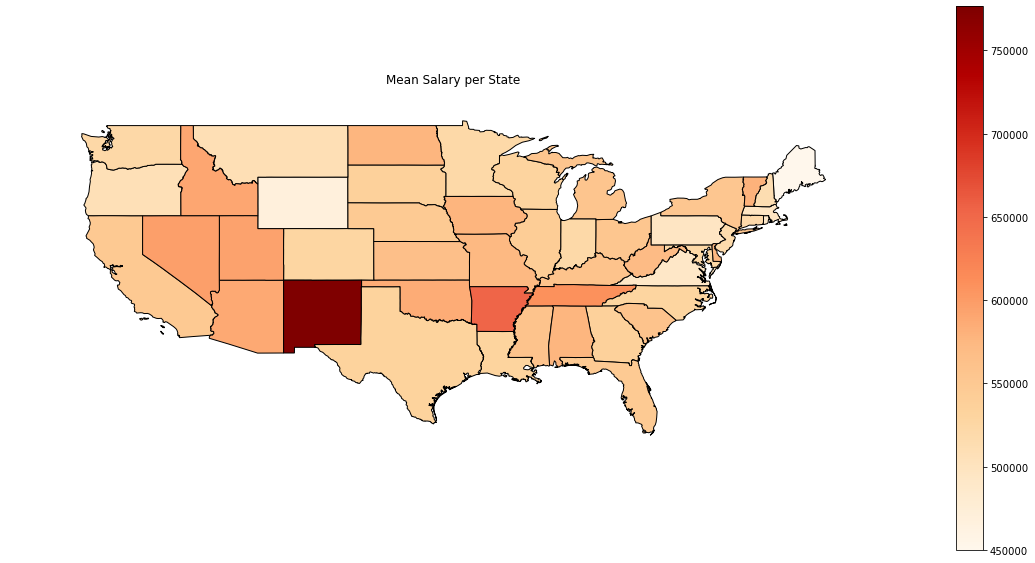

In [41]:
# Plot GeoPlot for Mean Salary per State visualization.

fig, ax = plt.subplots(figsize=(20,10))

gplt.choropleth(gdf[(gdf['STATE']!="ALASKA")&
    (gdf['STATE']!="HAWAII")],
                hue = "INCWAGE", 
                ax=ax,
                legend=True,
                cmap='OrRd'
                )
ax.set_title("Mean Salary per State")
fig.savefig('./images/average_wage_state_map.png')

New Mexico has the highest average income for the salary in range of 300,000 USD to 10M USD.

In [42]:
# Set dummy variables
df2 = pd.get_dummies(df2,prefix=['state_class'], drop_first=True)

### Dummy Variables

We made dummy variables for sex, race, marital status, veteran status, education level, disability to work, private insurance user, housing type, and more than $1 million of wage.

In [43]:
# Set male as dummy variable
df2['Male'] = df2.SEX.apply(lambda x: 1 if x == 1 else 0)

# Set race as dummy variables
df2['White'] = df2.RACE.apply(lambda x: 1 if x == 100 else 0)
df2['Black'] = df2.RACE.apply(lambda x: 1 if x == 200 else 0)
df2['Asian'] = df2.RACE.apply(lambda x: 1 if x == 651 else 0)

# Set marridge status as dummy variables
df2['Married'] = df2.MARST.apply(lambda x: 1 if x == 1 else 0)

# Set veteran status as dummy variables
df2['Veteran'] = df2.VETSTAT.apply(lambda x: 1 if x == 2 else 0)

# Set education level as dummy variable
df2['Undergrad'] = df2.EDUC.apply(lambda x: 1 if x >= 80 and x <= 122 else 0)
df2['Master'] = df2.EDUC.apply(lambda x: 1 if x >= 123 and x <= 124 else 0)
df2['Doctorate'] = df2.EDUC.apply(lambda x: 1 if x == 125 else 0)

# Set disability Work as dummy variable
df2['Disability_Work'] = df2.DISABWRK.apply(lambda x: 1 if x == 2 else 0)

# Set private insurance user as dummy variable
df2['Private_Insurance'] = df2.DISABWRK.apply(lambda x: 1 if x == 2 else 0)

# Set housing type dummy variable
df2['House_own'] = df2.HHTENURE.apply(lambda x: 1 if x == 1 else 0)
df2['House_rent'] = df2.HHTENURE.apply(lambda x: 1 if x == 2 else 0)

# Set our target dummy variable
df2['Wage_1m'] = df2.INCWAGE.apply(lambda x: 1 if x >= 1000000 else 0)

In [44]:
df2.head()

,YEAR,HHTENURE,STATEFIP,AGE,SEX,RACE,MARST,VETSTAT,NCHILD,EDUC,...,Married,Veteran,Undergrad,Master,Doctorate,Disability_Work,Private_Insurance,House_own,House_rent,Wage_1m
1102,2011,1.0,23,53,1,100,1,1,1,125,...,1,0,0,0,1,0,0,1,0,0
1630,2011,1.0,23,48,1,100,1,1,2,123,...,1,0,0,1,0,0,0,1,0,0
2738,2011,1.0,23,41,2,100,1,1,3,111,...,1,0,1,0,0,0,0,1,0,0
2916,2011,1.0,23,54,1,100,1,1,1,124,...,1,0,0,1,0,0,0,1,0,0
3143,2011,1.0,23,57,2,100,1,1,1,125,...,1,0,0,0,1,0,0,1,0,0


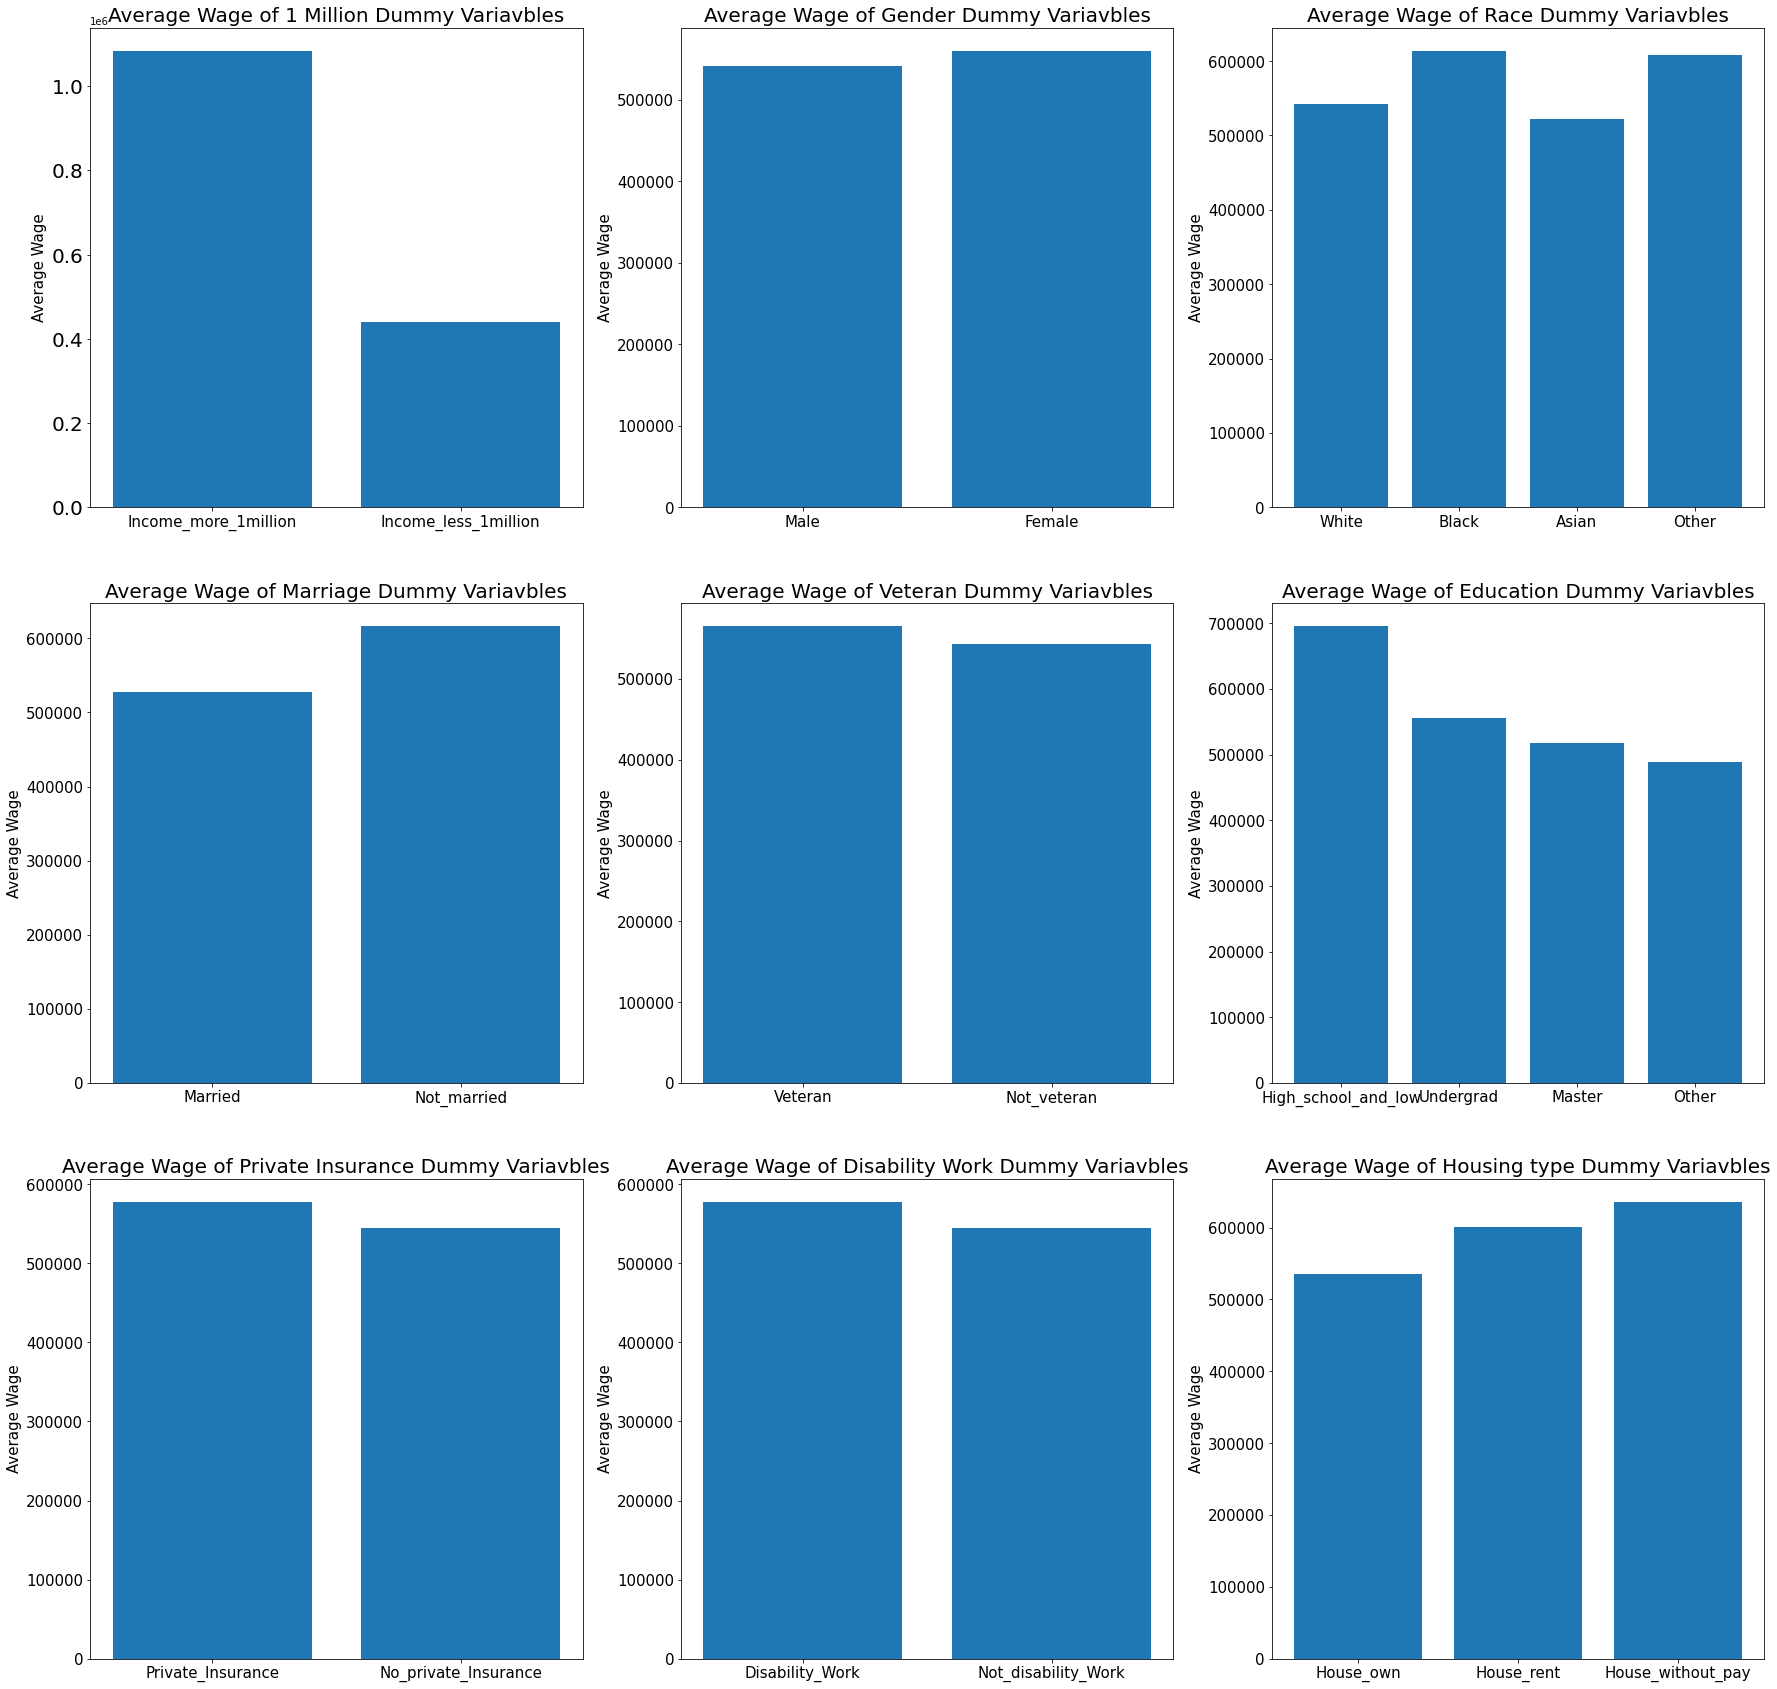

In [45]:
# make plot to show Average wage of each dummy variable
Income_more_1million = df2[df2.Wage_1m == 1].INCWAGE.mean()
Income_less_1million = df2[df2.Wage_1m == 0].INCWAGE.mean()
x1 = ['Income_more_1million', 'Income_less_1million']
y1 = [Income_more_1million, Income_less_1million]

Male = df2[df2.Male == 1].INCWAGE.mean()
Female = df2[df2.Male == 0].INCWAGE.mean()
x2 = ['Male', 'Female']
y2 = [Male, Female]

White = df2[df2.White == 1].INCWAGE.mean()
Black = df2[df2.Black == 1].INCWAGE.mean()
Asian = df2[df2.Asian == 1].INCWAGE.mean()
Other = df2[(df2.White == 0) & (df2.Black == 0) & (df2.Asian == 0)].INCWAGE.mean()
x3 = ['White', 'Black', 'Asian', 'Other']
y3 = [White, Black, Asian, Other]

Married = df2[df2.Married == 1].INCWAGE.mean()
Not_married = df2[df2.Married == 0].INCWAGE.mean()
x4 = ['Married', 'Not_married']
y4 = [Married, Not_married]

Veteran = df2[df2.Veteran == 1].INCWAGE.mean()
Not_veteran = df2[df2.Veteran == 0].INCWAGE.mean()
x5 = ['Veteran', 'Not_veteran']
y5 = [Veteran, Not_veteran]

High_school_and_low = df2[(df2.Undergrad == 0) & (df2.Master == 0) & (df2.Doctorate == 0)].INCWAGE.mean()
Undergrad = df2[df2.Undergrad == 1].INCWAGE.mean()
Master = df2[df2.Master == 1].INCWAGE.mean()
Doctorate = df2[df2.Doctorate == 1].INCWAGE.mean()
x6 = ['High_school_and_low', 'Undergrad', 'Master', 'Other']
y6 = [High_school_and_low, Undergrad, Master, Doctorate]

Private_Insurance = df2[df2.Private_Insurance == 1].INCWAGE.mean()
No_private_Insurance = df2[df2.Private_Insurance == 0].INCWAGE.mean()
x7 = ['Private_Insurance', 'No_private_Insurance']
y7 = [Private_Insurance, No_private_Insurance]

Disability_Work = df2[df2.Disability_Work == 1].INCWAGE.mean()
Not_disability_Work = df2[df2.Disability_Work == 0].INCWAGE.mean()
x8 = ['Disability_Work', 'Not_disability_Work']
y8 = [Disability_Work, Not_disability_Work]

House_own = df2[df2.House_own == 1].INCWAGE.mean()
House_rent = df2[df2.House_rent == 1].INCWAGE.mean()
House_without_pay = df2[(df2.House_own == 0) & (df2.House_rent == 0)].INCWAGE.mean()
x9 = ['House_own', 'House_rent', 'House_without_pay']
y9 = [House_own, House_rent, House_without_pay]


fig, axes = plt.subplots(3,3, figsize=(30,30))


axes[0][0].bar(x1, y1, label="Average Wage")
axes[0][0].set_title('Average Wage of 1 Million Dummy Variavbles', size = 20)
axes[0][0].set_ylabel('Average Wage', size = 15)
axes[0][0].tick_params(axis='x', labelsize=15)
axes[0][0].tick_params(axis='y', labelsize=20)

axes[0][1].bar(x2, y2, label="Average Wage")
axes[0][1].set_title('Average Wage of Gender Dummy Variavbles', size = 20)
axes[0][1].set_ylabel('Average Wage', size = 15)
axes[0][1].tick_params(axis='x', labelsize=15)
axes[0][1].tick_params(axis='y', labelsize=15)

axes[0][2].bar(x3, y3, label="Average Wage")
axes[0][2].set_title('Average Wage of Race Dummy Variavbles', size = 20)
axes[0][2].set_ylabel('Average Wage', size = 15)
axes[0][2].tick_params(axis='x', labelsize=15)
axes[0][2].tick_params(axis='y', labelsize=15)

axes[1][0].bar(x4, y4, label="Average Wage")
axes[1][0].set_title('Average Wage of Marriage Dummy Variavbles', size = 20)
axes[1][0].set_ylabel('Average Wage', size = 15)
axes[1][0].tick_params(axis='x', labelsize=15)
axes[1][0].tick_params(axis='y', labelsize=15)

axes[1][1].bar(x5, y5, label="Average Wage")
axes[1][1].set_title('Average Wage of Veteran Dummy Variavbles', size = 20)
axes[1][1].set_ylabel('Average Wage', size = 15)
axes[1][1].tick_params(axis='x', labelsize=15)
axes[1][1].tick_params(axis='y', labelsize=15)

axes[1][2].bar(x6, y6, label="Average Wage")
axes[1][2].set_title('Average Wage of Education Dummy Variavbles', size = 20)
axes[1][2].set_ylabel('Average Wage', size = 15)
axes[1][2].tick_params(axis='x', labelsize=15)
axes[1][2].tick_params(axis='y', labelsize=15)

axes[2][0].bar(x7, y7, label="Average Wage")
axes[2][0].set_title('Average Wage of Private Insurance Dummy Variavbles', size = 20)
axes[2][0].set_ylabel('Average Wage', size = 15)
axes[2][0].tick_params(axis='x', labelsize=15)
axes[2][0].tick_params(axis='y', labelsize=15)

axes[2][1].bar(x8, y8, label="Average Wage")
axes[2][1].set_title('Average Wage of Disability Work Dummy Variavbles', size = 20)
axes[2][1].set_ylabel('Average Wage', size = 15)
axes[2][1].tick_params(axis='x', labelsize=15)
axes[2][1].tick_params(axis='y', labelsize=15)

axes[2][2].bar(x9, y9, label="Average Wage")
axes[2][2].set_title('Average Wage of Housing type Dummy Variavbles', size = 20)
axes[2][2].set_ylabel('Average Wage', size = 15)
axes[2][2].tick_params(axis='x', labelsize=15)
axes[2][2].tick_params(axis='y', labelsize=15)

fig.savefig('./images/average_wage_dummy_variables.png')

In [46]:
# drop orginal variables
df2 = df2.drop(['YEAR', 'SEX', 'HHTENURE', 'RACE', 'MARST', 
                'VETSTAT', 'EDUC', 'DISABWRK', 'PHIOWN', 'INCWAGE', 
                'INDLY', 'OCCLY', 'STATEFIP'], axis=1)

## Data Overview

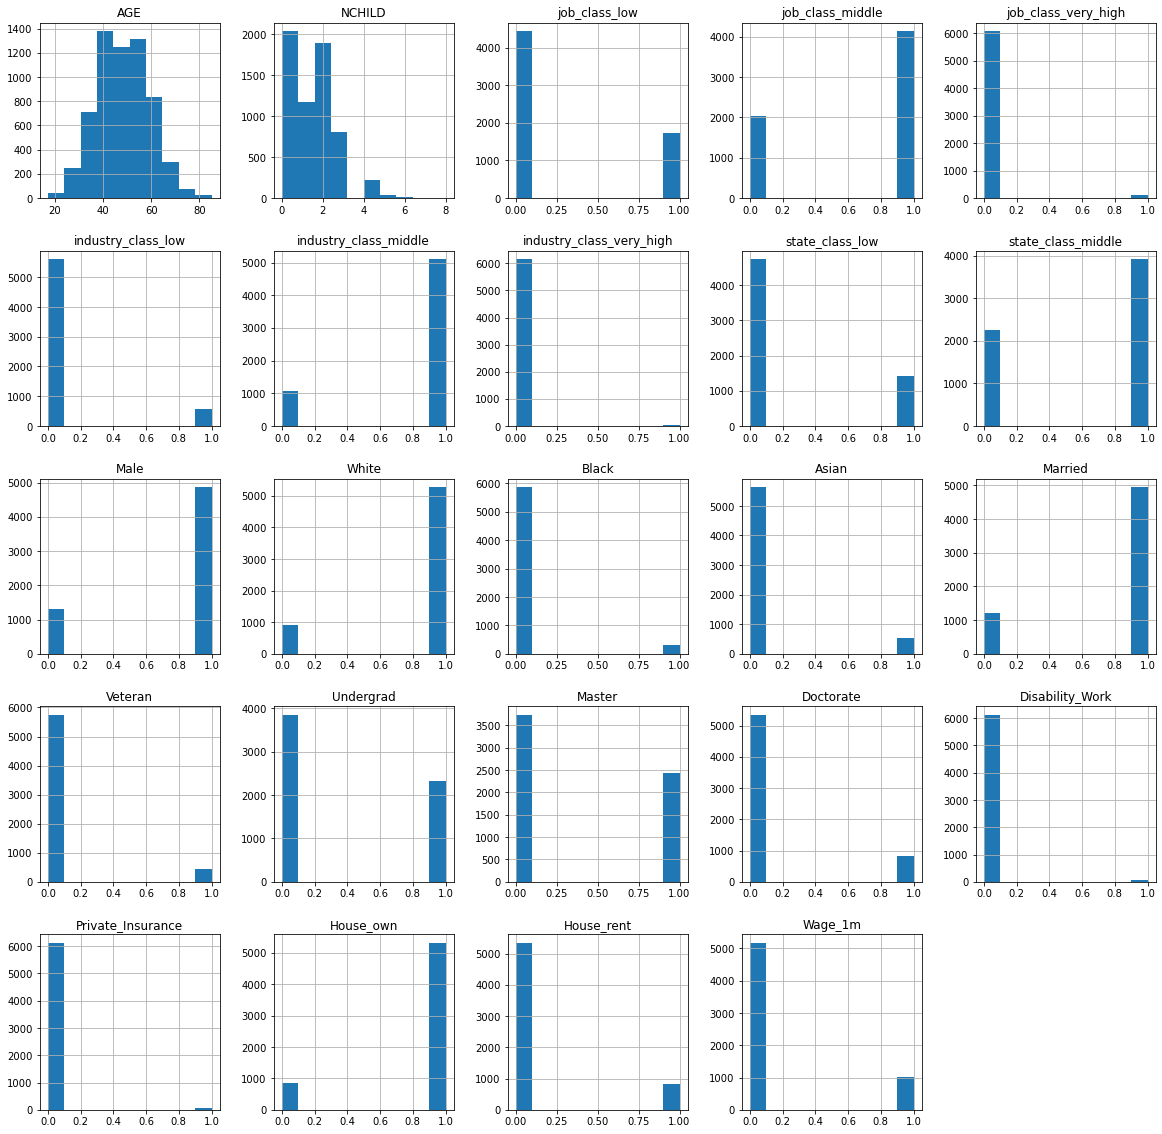

In [47]:
df2.hist(bins = 10, figsize = (20,20))
plt.savefig('./images/data_overview.png')

Most of the variables are quite imbalanced.

## Model Testing

We tested several models with different regressions. 

In [48]:
# Set target as Wage_1m and rest are variables.
X = df2.drop(['Wage_1m'],axis=1)
y = df2['Wage_1m']

In [49]:
# Split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2000)

### Dummy Model

In [50]:
# fit X_tran, y_train in dummy model
dummy_model = DummyClassifier(strategy="most_frequent")
dummy_model.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [51]:
dummy_cv_results = cross_val_score(dummy_model, X_train, y_train, cv=5)
dummy_cv_results

array([0.83405172, 0.83387271, 0.83387271, 0.83387271, 0.83387271])

In [52]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=5):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 5)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

In [53]:
dummy_model_results = ModelWithCV(
                        model=dummy_model,
                        model_name='dummy',
                        X=X_train, 
                        y=y_train
)

CV Results for `dummy` model:
            0.83391 ± 0.00007 accuracy
        


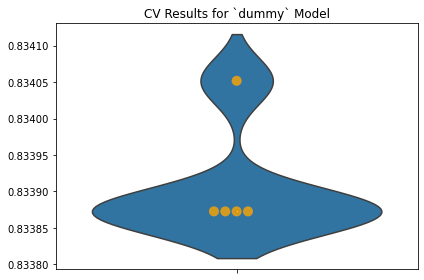

In [54]:
# plotting CV results for dummy model
fig, ax = plt.subplots()

ax = dummy_model_results.plot_cv(ax)
plt.tight_layout();

dummy_model_results.print_cv_summary()

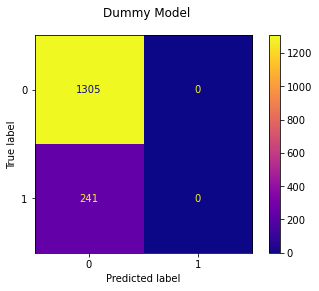

In [55]:
# dummy model confusion matrix
fig, ax = plt.subplots()

fig.suptitle("Dummy Model")

plot_confusion_matrix(dummy_model, X_test, y_test, ax=ax, cmap="plasma")


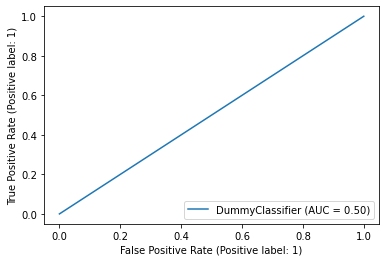

In [56]:
# dummy model ROC curve
plot_roc_curve(dummy_model,X_test,y_test)

AUC is not too great. We can do it better!

### KNN Model

In [57]:
# KNN model test
k_fold = KFold(n_splits=10, shuffle=True, random_state=2000)
kNN_clf = KNeighborsClassifier(n_neighbors = 13)
kNN_clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=13)

In [58]:
orig_knn_pred = kNN_clf.predict(X_test)

In [59]:
knn_orig_score = cross_val_score(estimator=kNN_clf, X=X,
                        y=y, cv=k_fold)
np.mean(knn_orig_score)

0.8353260557010733

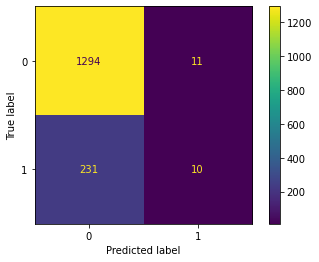

In [60]:
# KNN model confusion matrix
orig_knn_cm = plot_confusion_matrix(kNN_clf, X_test, y_test);

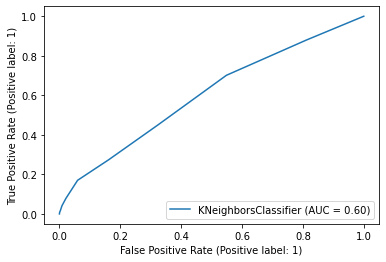

In [61]:
# KNN model ROC curve
orig_knn_roc = plot_roc_curve(kNN_clf, X_test, y_test)

In [62]:
# KNN mocel classification report
print(classification_report(y_test, orig_knn_pred))

              precision    recall  f1-score   support

           0       0.85      0.99      0.91      1305
           1       0.48      0.04      0.08       241

    accuracy                           0.84      1546
   macro avg       0.66      0.52      0.50      1546
weighted avg       0.79      0.84      0.78      1546



kNN result using original dataset is not too satisfying let's try more.

### KNN Model re-sampling

In [63]:
# Fit SMOTE to training data
X_train_resample, y_train_resample = SMOTE().fit_resample(X_train, y_train) 

# Preview synthetic sample class distribution
print(pd.Series(y_train_resample).value_counts()) 

1    3866
0    3866
Name: Wage_1m, dtype: int64


In [64]:
kNN_clf_resampled = KNeighborsClassifier(n_neighbors = 50)

In [65]:
# Fit the model
kNN_clf_resampled.fit(X_train_resample, y_train_resample)

KNeighborsClassifier(n_neighbors=50)

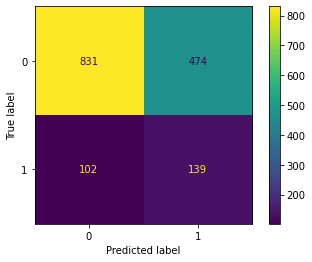

In [66]:
sampled_knn_cm = plot_confusion_matrix(kNN_clf_resampled, X_test, y_test);

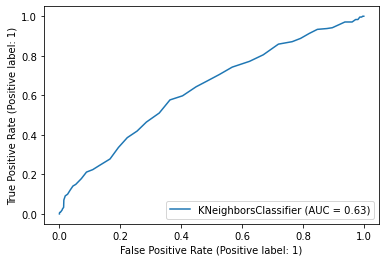

In [67]:
sampled_knn_roc = plot_roc_curve(kNN_clf_resampled, X_test, y_test)

In [68]:
sampled_knn_pred = kNN_clf_resampled.predict(X_test)

In [69]:
print(classification_report(y_test, sampled_knn_pred))

              precision    recall  f1-score   support

           0       0.89      0.64      0.74      1305
           1       0.23      0.58      0.33       241

    accuracy                           0.63      1546
   macro avg       0.56      0.61      0.53      1546
weighted avg       0.79      0.63      0.68      1546



After Resampling, the result is certainly better. Let's try another one after scaling.

### KNN Model re-sampling, scaling

In [70]:
def scale_values(X, scaler):
    """
    Given a DataFrame and a fitted scaler, use the scaler to scale all of the features
    """
    scaled_array = scaler.transform(X)
    scaled_df = pd.DataFrame(scaled_array, columns=X.columns, index=X.index)
    return scaled_df

In [71]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [72]:
X_train_resample_scaled = scale_values(X_train_resample, scaler)
X_test_scale = scale_values(X_test, scaler)

In [73]:
# Test optimal hyperparameter through cross validation.
for i in np.linspace(10,50,5).astype(int):
    kNN_clf_resampled_scaled = KNeighborsClassifier(n_neighbors = i)
    kNN_clf_resampled_scaled.fit(X_train, y_train)
    knn_sampled_scaled_score = cross_val_score(estimator=kNN_clf_resampled_scaled, X=X_train_resample_scaled,
                        y=y_train_resample, cv=k_fold)
    print("n_neighbor " + str(i) + " :"+ str(np.round(np.mean(knn_sampled_scaled_score)*100,2)))

n_neighbor 10 :81.22
n_neighbor 20 :80.43
n_neighbor 30 :79.27
n_neighbor 40 :78.62
n_neighbor 50 :78.17


n_neighbor = 10 seems like the best hyperparameter

In [74]:
kNN_clf_resampled_scaled = KNeighborsClassifier(n_neighbors = 10)

In [75]:
kNN_clf_resampled_scaled.fit(X_train_resample_scaled, y_train_resample)

KNeighborsClassifier(n_neighbors=10)

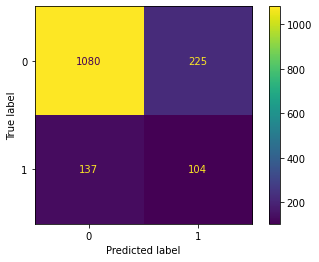

In [76]:
sampled_scaled_knn_cm = plot_confusion_matrix(kNN_clf_resampled_scaled, X_test_scale, y_test);

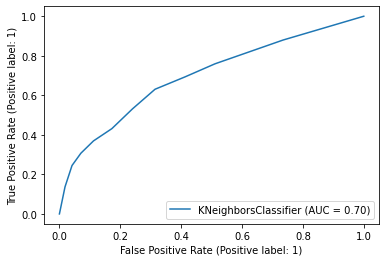

In [77]:
sampled_scaled_knn_cm  = plot_roc_curve(kNN_clf_resampled_scaled, X_test_scale, y_test)

In [78]:
sampled_scaled_knn_pred = kNN_clf_resampled_scaled.predict(X_test_scale)

In [79]:
print(classification_report(y_test, sampled_scaled_knn_pred))

              precision    recall  f1-score   support

           0       0.89      0.83      0.86      1305
           1       0.32      0.43      0.36       241

    accuracy                           0.77      1546
   macro avg       0.60      0.63      0.61      1546
weighted avg       0.80      0.77      0.78      1546



Model certainly looks the best after resampling & scaled!

### Decision Tree Model

Model was tested after resampling and scaling as we found out it delivers optimal result after previous modeling.

In [80]:
Tree_clf = DecisionTreeClassifier()

In [81]:
Tree_clf.fit(X_train_resample_scaled, y_train_resample)

DecisionTreeClassifier()

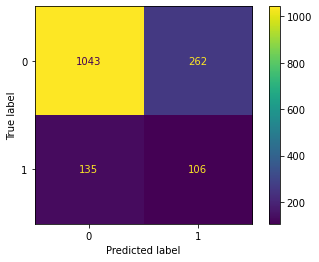

In [82]:
Tree_cf = plot_confusion_matrix(Tree_clf, X_test_scale, y_test);

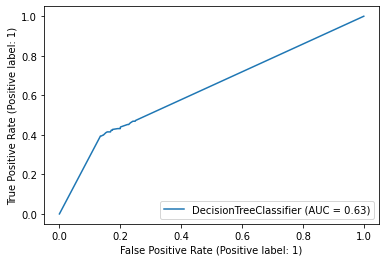

In [83]:
Tree_cf_roc = plot_roc_curve(Tree_clf, X_test_scale, y_test)

In [84]:
Tree_pred = Tree_clf.predict(X_test_scale)

In [85]:
print(classification_report(y_test, Tree_pred))

              precision    recall  f1-score   support

           0       0.89      0.80      0.84      1305
           1       0.29      0.44      0.35       241

    accuracy                           0.74      1546
   macro avg       0.59      0.62      0.59      1546
weighted avg       0.79      0.74      0.76      1546



Decision Tree model certainly NOT looking better than kNN model.

### Random Forest Model

In [86]:
# Cross Validation to decide best Hyperparameter
for i in np.linspace(10,100,10).astype(int):
    rf_clf = RandomForestClassifier(n_estimators=i)
    rf_clf.fit(X_train, y_train)
    rf_score = cross_val_score(estimator=rf_clf, X=X_train_resample_scaled,
                        y=y_train_resample, cv=k_fold)
    print("n_estimator " + str(i) + " :"+ str(np.round(np.mean(rf_score)*100,2)))

n_estimator 10 :85.32
n_estimator 20 :85.37
n_estimator 30 :85.32
n_estimator 40 :85.57
n_estimator 50 :85.58
n_estimator 60 :85.68
n_estimator 70 :85.59
n_estimator 80 :85.49
n_estimator 90 :85.93
n_estimator 100 :85.76


Optimum Hyperparameter = 70

In [87]:
rf_clf = RandomForestClassifier(n_estimators=100)

In [88]:
rf_clf.fit(X_train_resample_scaled, y_train_resample)

RandomForestClassifier()

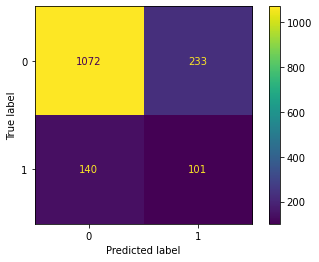

In [89]:
rf_cm = plot_confusion_matrix(rf_clf, X_test_scale, y_test);

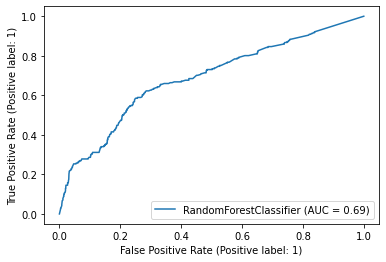

In [90]:
rf_roc = plot_roc_curve(rf_clf, X_test_scale, y_test)

In [91]:
rf_pred = rf_clf.predict(X_test_scale)

In [92]:
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.88      0.82      0.85      1305
           1       0.30      0.42      0.35       241

    accuracy                           0.76      1546
   macro avg       0.59      0.62      0.60      1546
weighted avg       0.79      0.76      0.77      1546



### Naive Bayes Model

In [93]:
nb_clf = GaussianNB()
nb_clf.fit(X_train_resample_scaled, y_train_resample)

GaussianNB()

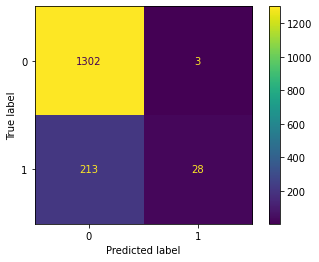

In [94]:
nb_cm = plot_confusion_matrix(nb_clf, X_test_scale, y_test);

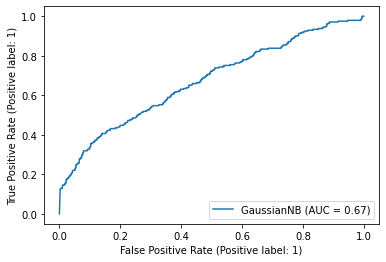

In [95]:
nb_roc = plot_roc_curve(nb_clf, X_test_scale, y_test)

In [96]:
nb_pred = nb_clf.predict(X_test_scale)

In [97]:
print(classification_report(y_test, nb_pred))

              precision    recall  f1-score   support

           0       0.86      1.00      0.92      1305
           1       0.90      0.12      0.21       241

    accuracy                           0.86      1546
   macro avg       0.88      0.56      0.56      1546
weighted avg       0.87      0.86      0.81      1546



Although Naive Bayes model has low recall score, it's impressive to have such a low false positive score.

### SVM Model

In [98]:
SVM_clf = SVC()
SVM_clf.fit(X_train_resample_scaled, y_train_resample)

SVC()

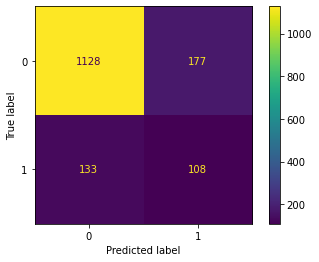

In [99]:
SVM_cm = plot_confusion_matrix(SVM_clf, X_test_scale, y_test);

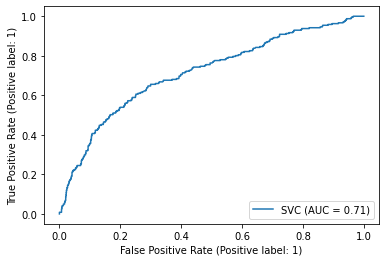

In [100]:
SVM_roc = plot_roc_curve(SVM_clf, X_test_scale, y_test)

In [101]:
SVM_pred = SVM_clf.predict(X_test_scale)

In [102]:
print(classification_report(y_test, SVM_pred))

              precision    recall  f1-score   support

           0       0.89      0.86      0.88      1305
           1       0.38      0.45      0.41       241

    accuracy                           0.80      1546
   macro avg       0.64      0.66      0.64      1546
weighted avg       0.81      0.80      0.81      1546



AUC is quite impressive based on roc_curve, but its false positive rate is still pretty high.

### Logistic Regression

In [103]:
# fit X_tran, y_train in logistic regression model
lr = LogisticRegression(random_state=2000, penalty='none')

lr.fit(X_train, y_train)

LogisticRegression(penalty='none', random_state=2000)

In [104]:
scores = cross_val_score(estimator=lr, X=X_train,
                        y=y_train, cv=5)
scores

array([0.85021552, 0.85329018, 0.85113269, 0.85868393, 0.84466019])

In [105]:
lr.score(X_test, y_test)

0.8615782664941786

In [106]:
lr.coef_

array([[-0.0068439 , -0.06081684, -2.72719737, -1.45759127,  2.35603535,
        -2.05519172, -0.90565671,  0.76767259, -0.77010651, -0.36475387,
         0.08023357,  0.34710951,  0.23929738,  0.59160143, -0.30839087,
         0.21013835, -0.35564497, -0.39220636, -0.45707756, -0.06109506,
        -0.06109506,  0.60602199,  0.49953546]])

In [107]:
lr.intercept_

array([1.14429734])

In [108]:
lr_results = ModelWithCV(
                        model=lr,
                        model_name='simple_logreg',
                        X=X_train, 
                        y=y_train
)

CV Results for `simple_logreg` model:
            0.85160 ± 0.00455 accuracy
        


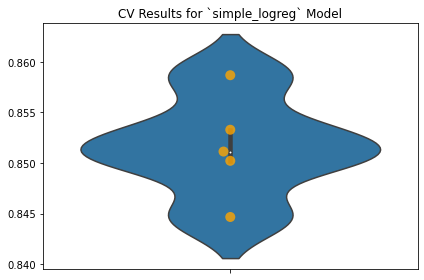

In [109]:
# Saving variable for convenience
model_results = lr_results

# Plot CV results
fig, ax = plt.subplots()
ax = model_results.plot_cv(ax)
plt.tight_layout();
# Print CV results
model_results.print_cv_summary()

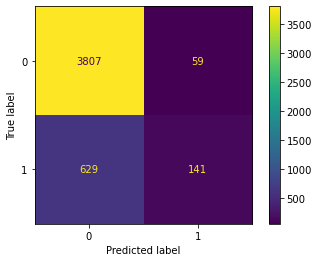

In [110]:
plot_confusion_matrix(lr, X_train, y_train)


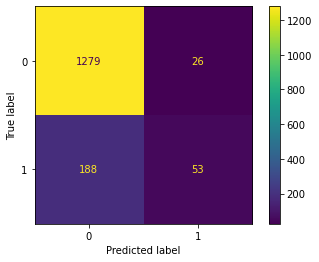

In [111]:
plot_confusion_matrix(lr, X_test, y_test)


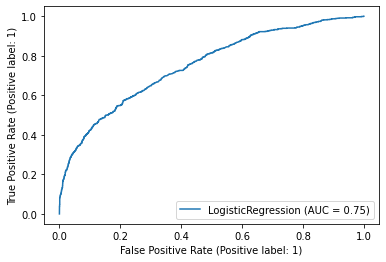

In [112]:
plot_roc_curve(lr, X_train, y_train)


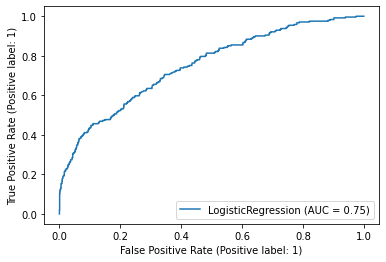

In [113]:
plot_roc_curve(lr, X_test, y_test)


### Logistic Regression re-sampling

In [114]:
# Previous original class distribution
print(y_train.value_counts())

# Fit SMOTE to training data
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train) 

# Preview synthetic sample class distribution
print('\n')
print(pd.Series(y_train_resampled).value_counts()) 

0    3866
1     770
Name: Wage_1m, dtype: int64


1    3866
0    3866
Name: Wage_1m, dtype: int64


In [115]:
lr2 = LogisticRegression(random_state=2000, penalty='none')

lr2.fit(X_train_resampled, y_train_resampled)

LogisticRegression(penalty='none', random_state=2000)

In [116]:
scores = cross_val_score(estimator=lr2, X=X_train_resampled,
                        y=y_train_resampled, cv=5)
scores

array([0.62895928, 0.83063995, 0.82341527, 0.83376455, 0.82923674])

In [117]:
lr2.score(X_test, y_test)

0.7981888745148771

In [118]:
lr2.coef_

array([[-1.80750043e-03, -8.30172436e-02, -3.73982662e+00,
        -2.11627781e+00,  1.69626397e+00, -3.29913187e+00,
        -1.14898647e+00,  7.84486769e-01, -1.69145714e+00,
        -1.04162927e+00, -7.22337415e-02, -2.34715637e+00,
        -3.59404772e+00, -2.87374149e+00, -3.62891503e-01,
        -6.94357349e-01, -1.41533928e+00, -1.16968691e+00,
        -2.12044276e+00, -6.37008703e-01, -6.37008703e-01,
        -2.39326548e+00, -3.37938742e+00]])

In [119]:
lr2.intercept_

array([10.53853057])

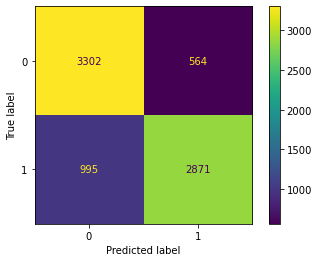

In [120]:
plot_confusion_matrix(lr2, X_train_resampled, y_train_resampled);

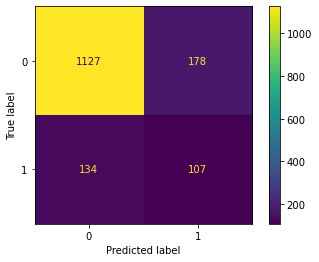

In [121]:
plot_confusion_matrix(lr2, X_test, y_test)

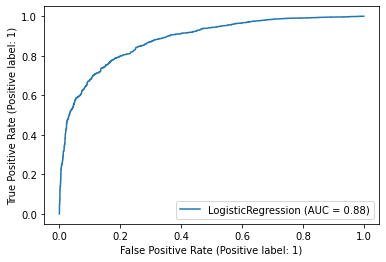

In [122]:
plot_roc_curve(lr2, X_train_resampled, y_train_resampled)

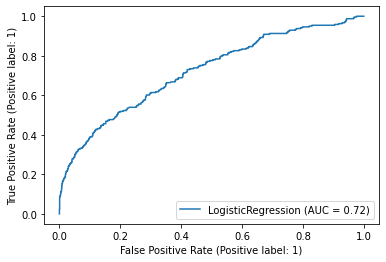

In [123]:
plot_roc_curve(lr2, X_test, y_test)

### More Iteration, Higher Tolerance Logistic Regression

In [124]:
lr2_more_iterations = LogisticRegression(
                                                random_state=2000, 
                                                penalty='none', 
                                                max_iter=100000
)
lr2_more_iterations.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=100000, penalty='none', random_state=2000)

In [125]:
lr2_higher_tolerance = LogisticRegression(
                                                random_state=2000, 
                                                penalty='none', 
                                                tol=25
)
lr2_higher_tolerance.fit(X_train_resampled, y_train_resampled)

LogisticRegression(penalty='none', random_state=2000, tol=25)

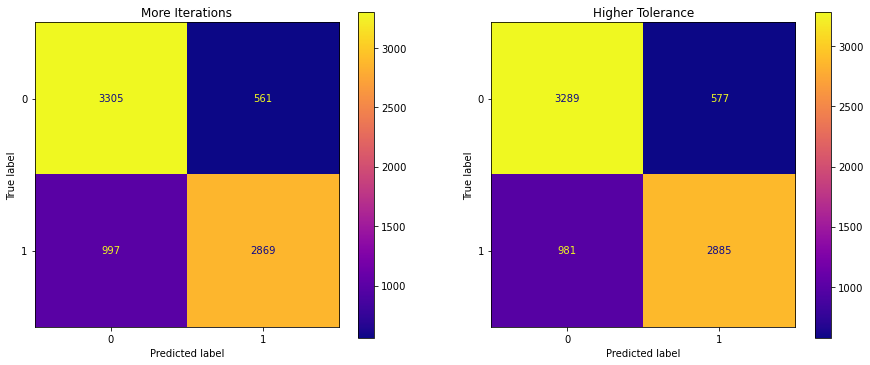

In [126]:
fix, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

axes[0].set_title("More Iterations")
axes[1].set_title("Higher Tolerance")

plot_confusion_matrix(lr2_more_iterations, X_train_resampled, y_train_resampled,
                      ax=axes[0], cmap="plasma")
plot_confusion_matrix(lr2_higher_tolerance, X_train_resampled, y_train_resampled,
                      ax=axes[1], cmap="plasma");

In [127]:
logreg_model_more_iterations_results = ModelWithCV(
                                        lr2_more_iterations,
                                        'more_iterations',
                                        X_train_resampled,
                                        y_train_resampled
)
    
logreg_model_higher_tolerance_results = ModelWithCV(
                                        lr2_higher_tolerance,
                                        'higher_tolerance',
                                        X_train_resampled,
                                        y_train_resampled
)

model_results = [
    logreg_model_more_iterations_results,
    logreg_model_higher_tolerance_results
]

CV Results for `more_iterations` model:
            0.79218 ± 0.08325 accuracy
        
CV Results for `higher_tolerance` model:
            0.78933 ± 0.08026 accuracy
        


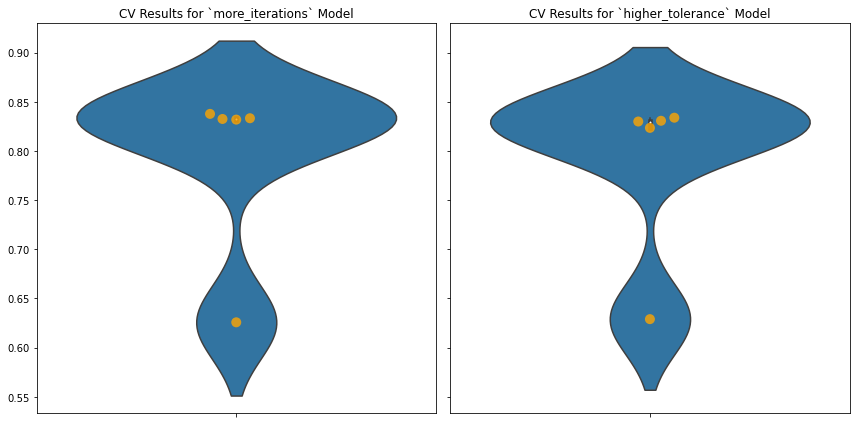

In [128]:
f,axes = plt.subplots(ncols=2,sharey=True, figsize=(12,6))

for ax,result in zip(axes,model_results):
    ax = result.plot_cv(ax)
    result.print_cv_summary()
plt.tight_layout();

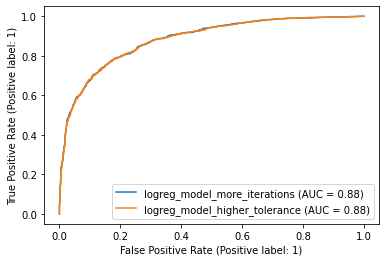

In [129]:
fig, ax = plt.subplots()

plot_roc_curve(lr2_more_iterations, X_train_resampled, y_train_resampled, 
               name='logreg_model_more_iterations', ax=ax)
plot_roc_curve(lr2_higher_tolerance, X_train_resampled, y_train_resampled, 
               name='logreg_model_higher_tolerance', ax=ax)

### Logistic Regression re-sampling, scaling

In [130]:
scaler = StandardScaler()

scaler.fit(X_train)

StandardScaler()

In [131]:
def scale_values(X, scaler):
    """
    Given a DataFrame and a fitted scaler, use the scaler to scale all of the features
    """
    scaled_array = scaler.transform(X)
    scaled_df = pd.DataFrame(scaled_array, columns=X.columns, index=X.index)
    return scaled_df

In [132]:
X_train_resampled_scaled = scale_values(X_train_resampled, scaler)
X_test_scaled = scale_values(X_test, scaler)


In [133]:
X_train_resampled_scaled.head()

,AGE,NCHILD,job_class_low,job_class_middle,job_class_very_high,industry_class_low,industry_class_middle,industry_class_very_high,state_class_low,state_class_middle,...,Asian,Married,Veteran,Undergrad,Master,Doctorate,Disability_Work,Private_Insurance,House_own,House_rent
0,-0.390117,0.501906,1.609663,-1.435293,-0.123817,-0.320152,0.458742,-0.046494,1.826681,-1.320916,...,-0.308133,0.495209,-0.272748,-0.779774,1.238838,-0.393281,-0.09446,-0.09446,0.406346,-0.4002
1,0.262969,-0.314815,-0.621248,0.696722,-0.123817,-0.320152,0.458742,-0.046494,1.826681,-1.320916,...,-0.308133,0.495209,-0.272748,1.282423,-0.807208,-0.393281,-0.09446,-0.09446,0.406346,-0.4002
2,0.169671,2.135348,-0.621248,0.696722,-0.123817,-0.320152,0.458742,-0.046494,-0.547441,-1.320916,...,-0.308133,0.495209,-0.272748,-0.779774,1.238838,-0.393281,-0.09446,-0.09446,0.406346,-0.4002
3,-1.043203,-0.314815,1.609663,-1.435293,-0.123817,-0.320152,0.458742,-0.046494,-0.547441,-1.320916,...,-0.308133,0.495209,-0.272748,-0.779774,1.238838,-0.393281,-0.09446,-0.09446,0.406346,-0.4002
4,-1.136502,0.501906,-0.621248,0.696722,-0.123817,3.123521,-2.179876,-0.046494,-0.547441,0.757050,...,-0.308133,0.495209,-0.272748,-0.779774,1.238838,-0.393281,-0.09446,-0.09446,0.406346,-0.4002


In [134]:
lr3 = LogisticRegression(random_state=2000, max_iter=100000)
lr3.fit(X_train_resampled_scaled, y_train_resampled)

LogisticRegression(max_iter=100000, random_state=2000)

In [135]:
lr3.score(X_test_scaled, y_test)

0.7994825355756792

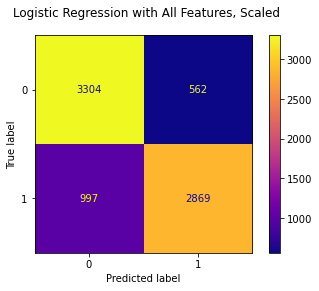

In [136]:
fig, ax = plt.subplots()

fig.suptitle("Logistic Regression with All Features, Scaled")

plot_confusion_matrix(lr3, X_train_resampled_scaled, y_train_resampled, ax=ax, cmap="plasma");

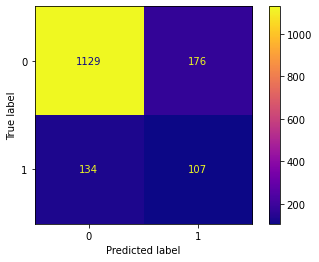

In [137]:
plot_confusion_matrix(lr3, X_test_scaled, y_test, cmap="plasma")

In [138]:
all_features_results = ModelWithCV(
                            lr2_more_iterations,
                            'More_iterations',
                            X_train_resampled,
                            y_train_resampled
)

CV Results for `More_iterations` model:
            0.79218 ± 0.08325 accuracy
        


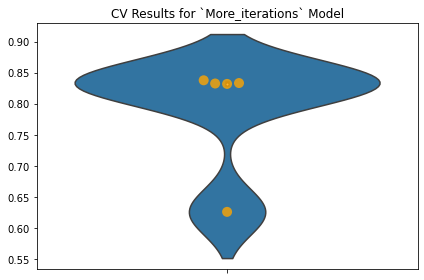

In [139]:
# Saving variable for convenience
model_results = all_features_results

# Plot CV results
fig, ax = plt.subplots()
ax = model_results.plot_cv(ax)
plt.tight_layout();
# Print CV results
model_results.print_cv_summary()

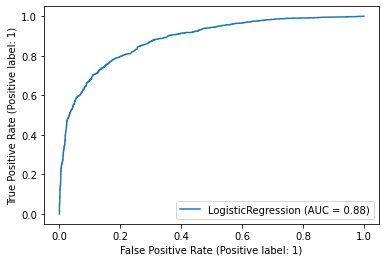

In [140]:
plot_roc_curve(lr2_more_iterations, X_train_resampled, y_train_resampled)

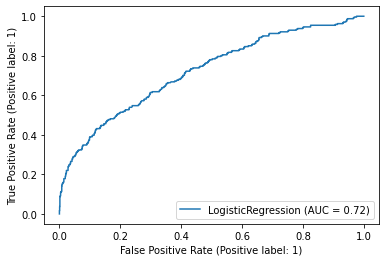

In [141]:
plot_roc_curve(lr2_more_iterations, X_test, y_test)

In [142]:
all_features_results.print_cv_summary()

CV Results for `More_iterations` model:
            0.79218 ± 0.08325 accuracy
        


In [143]:
model_results = [all_features_results]
C_values = [0.0001,0.001,0.01,0.1,1]

for c in C_values:
    lr2 = LogisticRegression(random_state=2000,max_iter=100000, C=c)
    lr2.fit(X_train_resampled, y_train_resampled)
    # Save Results
    new_model_results = ModelWithCV(
                            lr3,
                            f'all_features_c{c:e}',
                            X_train_resampled,
                            y_train_resampled
    )
    model_results.append(new_model_results)
    new_model_results.print_cv_summary()

CV Results for `all_features_c1.000000e-04` model:
            0.79192 ± 0.08285 accuracy
        
CV Results for `all_features_c1.000000e-03` model:
            0.79192 ± 0.08285 accuracy
        
CV Results for `all_features_c1.000000e-02` model:
            0.79192 ± 0.08285 accuracy
        
CV Results for `all_features_c1.000000e-01` model:
            0.79192 ± 0.08285 accuracy
        
CV Results for `all_features_c1.000000e+00` model:
            0.79192 ± 0.08285 accuracy
        


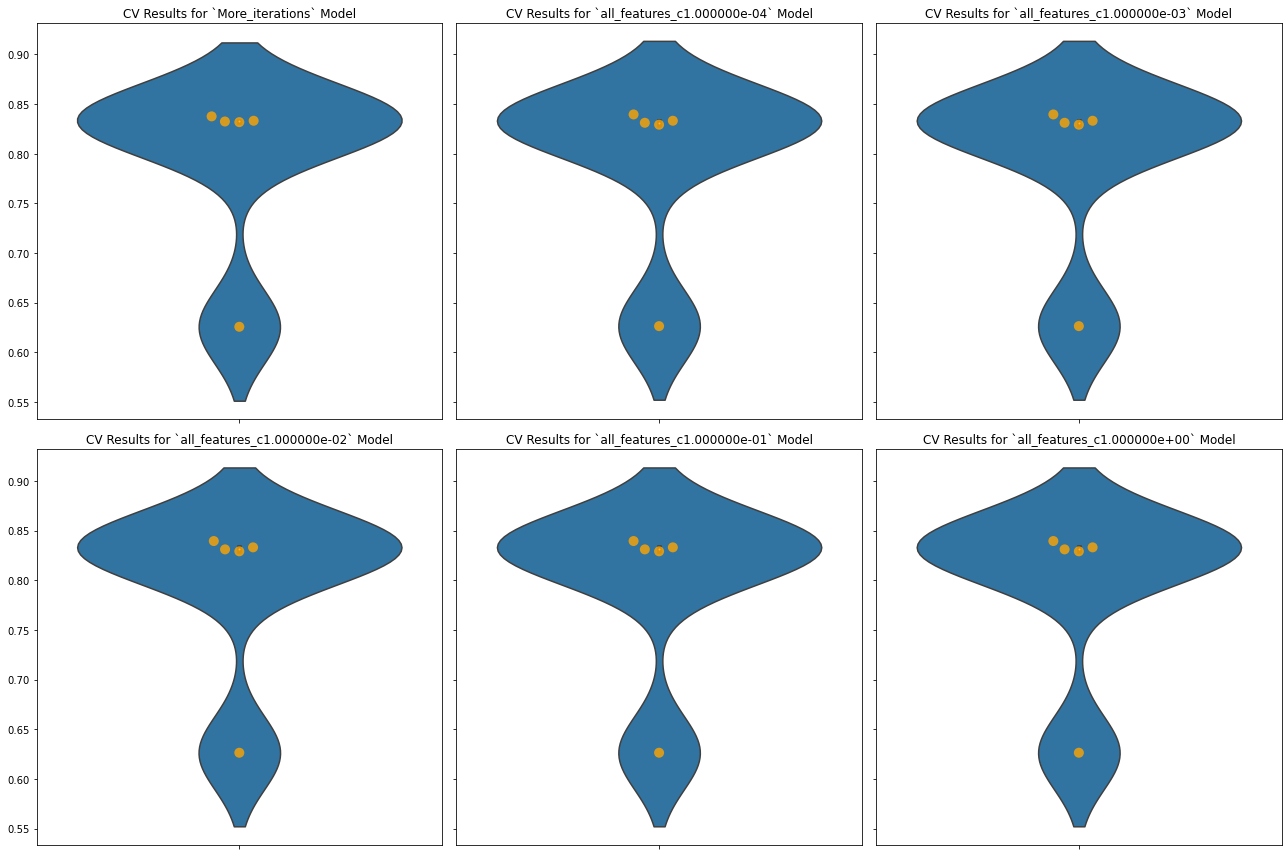

In [144]:
f,axes = plt.subplots(ncols=3,nrows=2, sharey='all', figsize=(18,12))

for ax,result in zip(axes.ravel(),model_results):
    ax = result.plot_cv(ax)

plt.tight_layout();

In [145]:
model_results = [all_features_results]
all_features_cross_val_score = all_features_results.cv_results

In [146]:
lr2 = LogisticRegression(random_state=2000, max_iter=100000, solver="liblinear")
lr2.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=100000, random_state=2000, solver='liblinear')

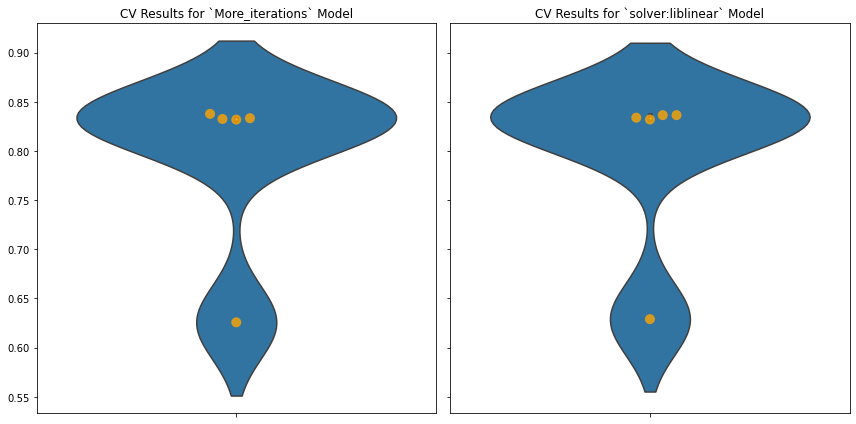

In [147]:
# Save for later comparison
model_results.append(
    ModelWithCV(
        lr2, 
        'solver:liblinear',
        X_train_resampled,
        y_train_resampled
    )
)

# Plot both all_features vs new model
f,axes = plt.subplots(ncols=2, sharey='all', figsize=(12,6))

model_results[0].plot_cv(ax=axes[0])
model_results[-1].plot_cv(ax=axes[1])

plt.tight_layout();

In [148]:
print("Old:", all_features_cross_val_score)
print("New:", model_results[-1].cv_results)
print("New:", model_results[-1].cv_mean)

Old: [0.62572721 0.8332256  0.83247089 0.83764554 0.83182406]
New: [0.62895928 0.83193277 0.83635188 0.83635188 0.83376455]
New: 0.7934720708862708


In [149]:
lr2 = LogisticRegression(random_state=2000, solver="liblinear", max_iter=100000, penalty="l1")
lr2.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=100000, penalty='l1', random_state=2000,
                   solver='liblinear')

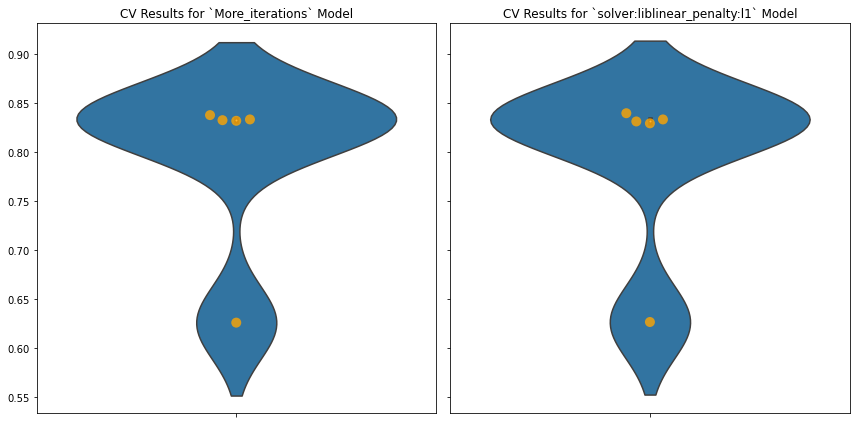

In [150]:
# Save for later comparison
model_results.append(
    ModelWithCV(
        lr3, 
        'solver:liblinear_penalty:l1',
        X_train_resampled,
        y_train_resampled
    )
)

# Plot both all_features vs new model
f,axes = plt.subplots(ncols=2, sharey='all', figsize=(12,6))

model_results[0].plot_cv(ax=axes[0])
model_results[-1].plot_cv(ax=axes[1])

plt.tight_layout();

In [151]:
print("Old:", all_features_cross_val_score)
print("New:", model_results[-1].cv_results)
print("New:", model_results[-1].cv_mean)

Old: [0.62572721 0.8332256  0.83247089 0.83764554 0.83182406]
New: [0.62637363 0.8332256  0.83117723 0.83958603 0.82923674]
New: 0.7919198448610214


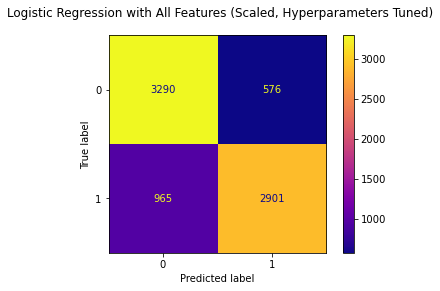

In [152]:
lr2 = LogisticRegression(random_state=2000, solver="liblinear", max_iter=100000)
lr2.fit(X_train_resampled, y_train_resampled)

fig, ax = plt.subplots()

fig.suptitle("Logistic Regression with All Features (Scaled, Hyperparameters Tuned)")

plot_confusion_matrix(lr2, X_train_resampled, y_train_resampled, ax=ax, cmap="plasma");

### Models Comparison and Final Model Selection

In [153]:
final_model = GaussianNB()
final_model.fit(X_train_resample_scaled, y_train_resample)

final_model.score(X_test_scale, y_test)

0.8602846054333765

In [154]:
# Create a way to categorize our different models
model_candidates = [
    {
        'name':'dummy_model'
        ,'model':dummy_model
        ,'X_test':X_test
        ,'y_test':y_test
    },
        {
        'name':'kNN_Model'
        ,'model':kNN_clf_resampled_scaled
        ,'X_test':X_test_scale
        ,'y_test':y_test
    },
    {
        'name':'Dec_Tree_Model'
        ,'model':Tree_clf
        ,'X_test':X_test_scale
        ,'y_test':y_test
    },
    {
        'name':'Random_Forest_Model'
        ,'model':rf_clf
        ,'X_test':X_test_scale
        ,'y_test':y_test
    },
    {
        'name':'Naive_Bayes_Model'
        ,'model':nb_clf
        ,'X_test':X_test_scale
        ,'y_test':y_test
    },
    {
        'name':'SVM_Model'
        ,'model':SVM_clf
        ,'X_test':X_test_scale
        ,'y_test':y_test
    },
    {
        'name':'simple_logreg_model'
        ,'model':lr
        ,'X_test':X_test
        ,'y_test':y_test
    },
    {
        'name':'logreg_model_more_iterations'
        ,'model':lr2_more_iterations
        ,'X_test':X_test
        ,'y_test':y_test
    },
    {
        'name':'logreg_model_higher_tolerance'
        ,'model':lr2_higher_tolerance
        ,'X_test':X_test
        ,'y_test':y_test
    },
    {
        'name':'final_model'
        ,'model':final_model
        ,'X_test':X_test_scale
        ,'y_test':y_test
    }
]

In [155]:
final_scores_dict = {
    "Model Name": [candidate.get('name') for candidate in model_candidates],
    "Mean Accuracy": [
        candidate.get('model').score(
                                candidate.get('X_test'), 
                                candidate.get('y_test')
        ) 
        for candidate in model_candidates
    ]
    
}
final_scores_df = pd.DataFrame(final_scores_dict).set_index('Model Name')
final_scores_df

,Mean Accuracy
Model Name,
dummy_model,0.844114
kNN_Model,0.765847
Dec_Tree_Model,0.743208
Random_Forest_Model,0.758732
Naive_Bayes_Model,0.860285
SVM_Model,0.799483
simple_logreg_model,0.861578
logreg_model_more_iterations,0.799483
logreg_model_higher_tolerance,0.798189


Naive Bayes model is standing out in terms of accuracy.

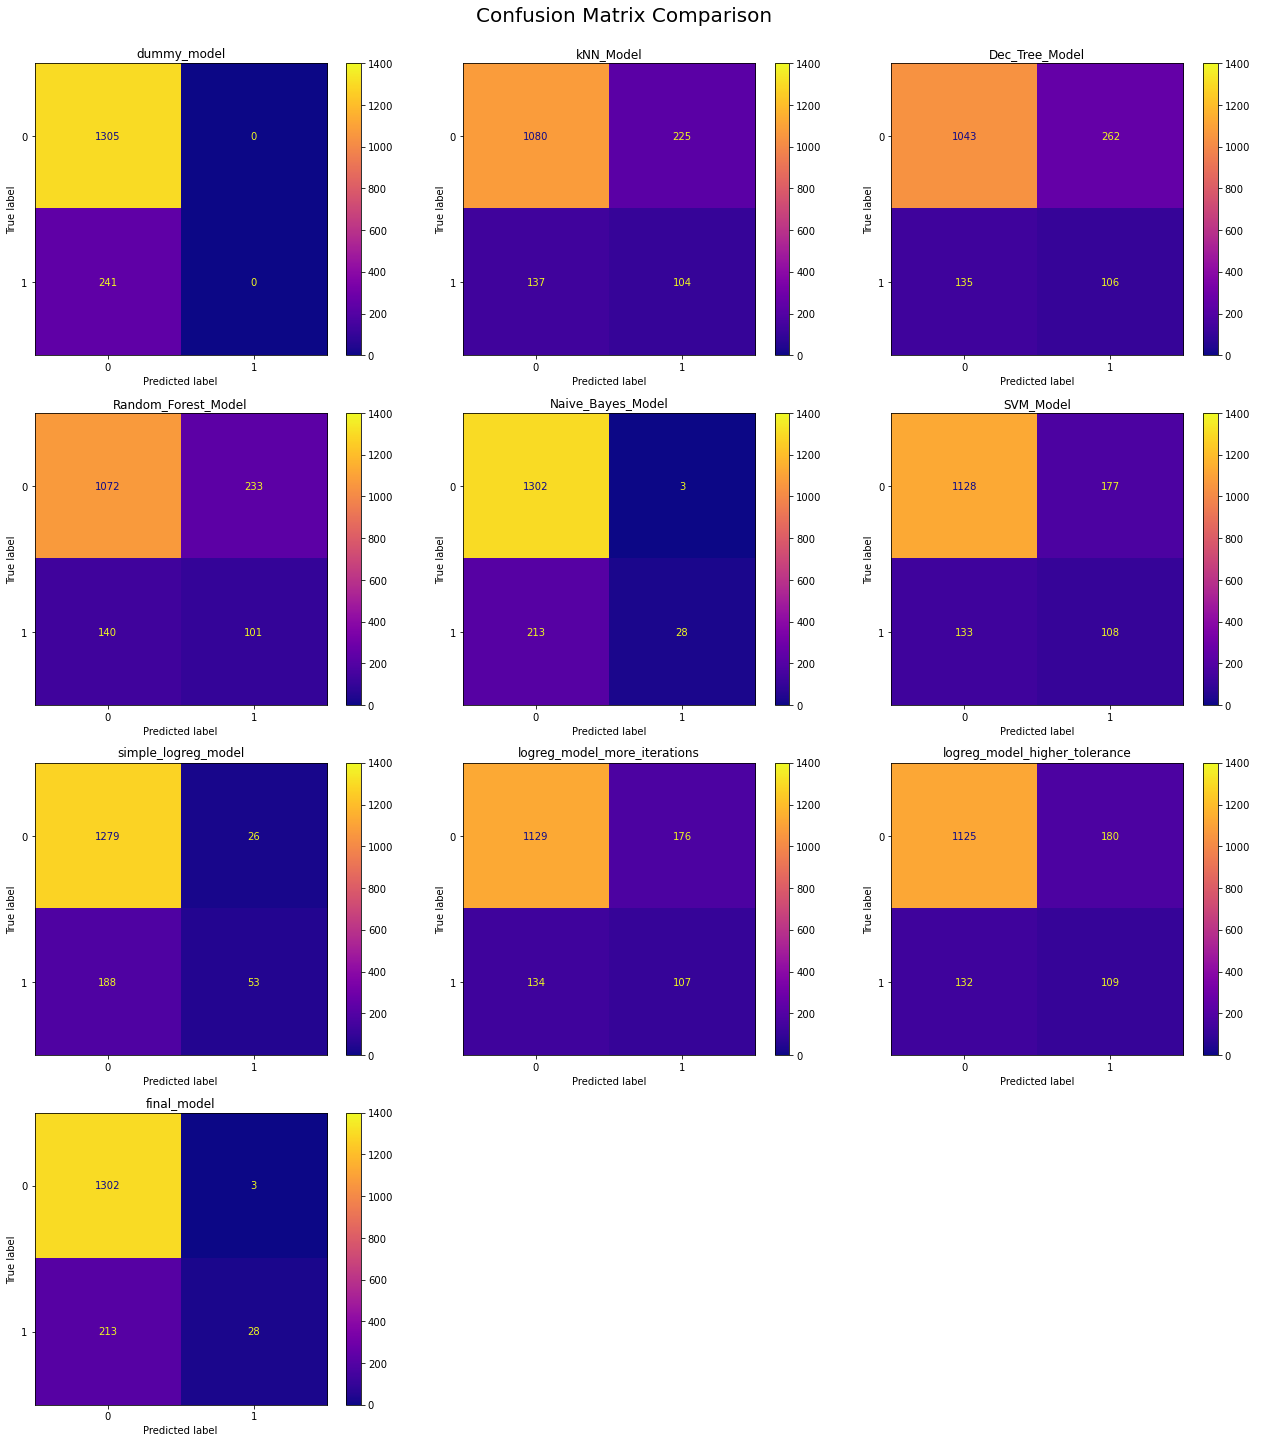

In [156]:
nrows = 4
ncols = math.ceil(len(model_candidates)/nrows)

fig, axes = plt.subplots(
                nrows=nrows,
                ncols=ncols,
                figsize=(18, 20)
)
fig.suptitle("Confusion Matrix Comparison", size = 20, y=1)

# Turn off all the axes (in case nothing to plot); turn on while iterating over
[ax.axis('off') for ax in axes.ravel()]


for i,candidate in enumerate(model_candidates):
    # Logic for making rows and columns for matrices
    row = i // 3
    col = i % 3
    ax = axes[row][col]
    
    ax.set_title(candidate.get('name'))
    ax.set_axis_on() 
    cm_display = plot_confusion_matrix(
                    candidate.get('model'),
                    candidate.get('X_test'),
                    candidate.get('y_test'),
                    cmap='plasma',
                    ax=ax,
                    
    )
    cm_display.im_.set_clim(0, 1400)

plt.tight_layout()

We are leaning towards Navie Bayes as our optimal model as it has the lowest False Postiive Rate while maintaining some True Positive Rate. This is significant because we should minimize our risk of sending invitation to people who are not appropriate to receive.

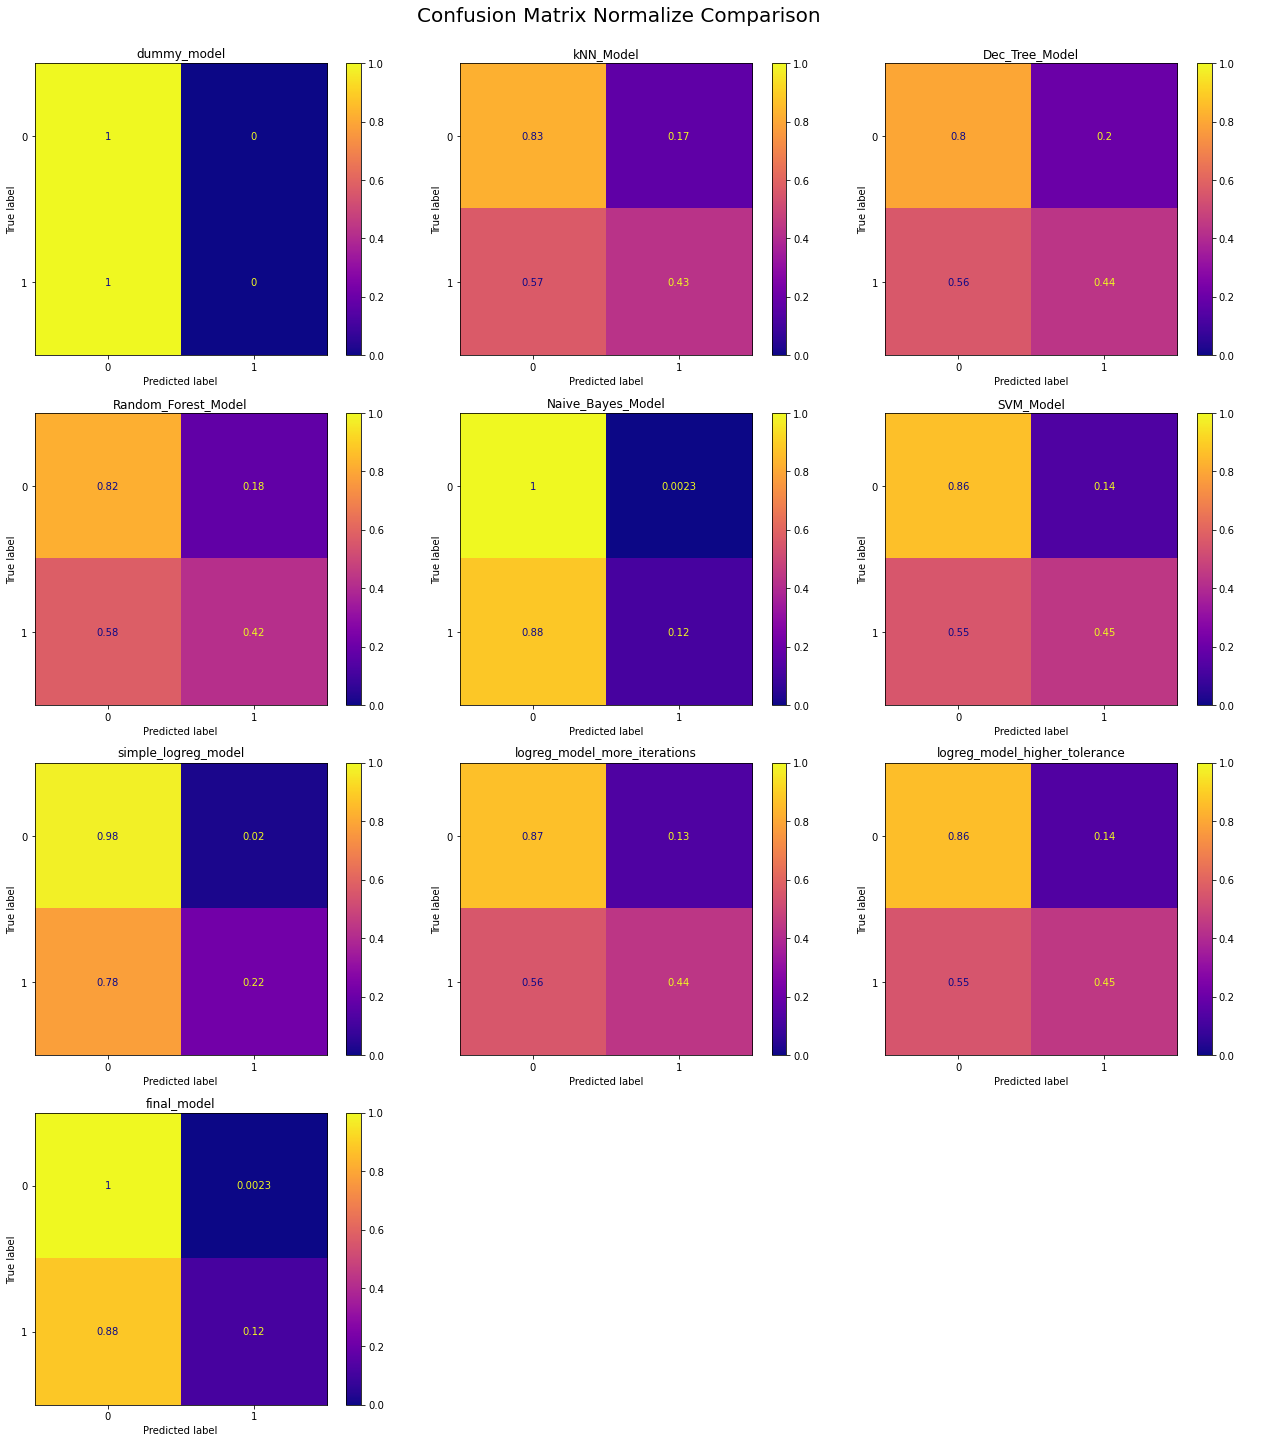

In [157]:
nrows = 4
ncols = math.ceil(len(model_candidates)/nrows)

fig, axes = plt.subplots(
                nrows=nrows,
                ncols=ncols,
                figsize=(18, 20)
)
fig.suptitle("Confusion Matrix Normalize Comparison", size = 20, y=1)

# Turn off all the axes (in case nothing to plot); turn on while iterating over
[ax.axis('off') for ax in axes.ravel()]


for i,candidate in enumerate(model_candidates):
    # Logic for making rows and columns for matrices
    row = i // 3
    col = i % 3
    ax = axes[row][col]
    
    ax.set_title(candidate.get('name'))
    ax.set_axis_on() 
    cm_display = plot_confusion_matrix(
                    candidate.get('model'),
                    candidate.get('X_test'),
                    candidate.get('y_test'),
                    normalize='true',
                    cmap='plasma',
                    ax=ax,
                    
    )
    cm_display.im_.set_clim(0, 1)

plt.tight_layout()

fig.savefig('./images/Confusion Matrix Normalize Comparison.png')

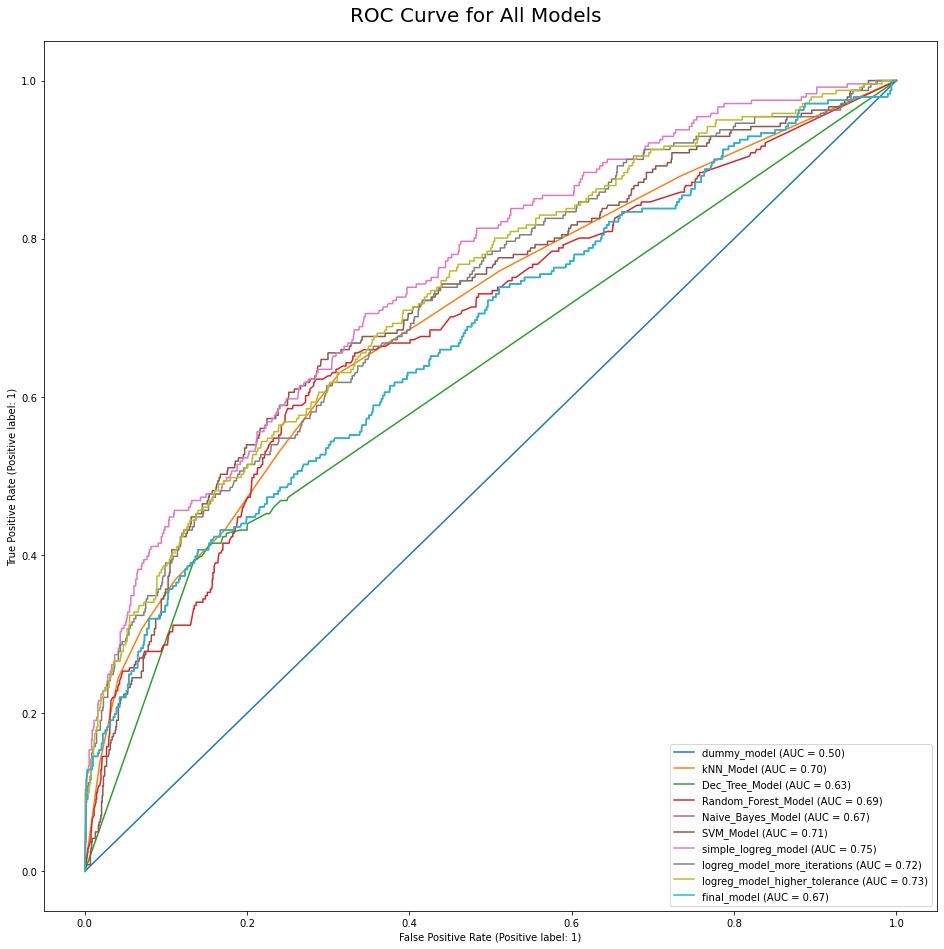

In [158]:
fig, ax = plt.subplots(figsize=(16,16))

fig.suptitle("ROC Curve for All Models", size = 20, y=0.91)
# Plot only the last models we created (so it's not too cluttered)
for model_candidate in model_candidates:
    plot_roc_curve(
        model_candidate.get('model'),
        model_candidate.get('X_test'),
        model_candidate.get('y_test'), 
        name=model_candidate.get('name'),
        ax=ax
    )
    
fig.savefig('./images/ROC_curve_all_model.png')

### Precision, Recall, F1-Score

In [159]:
simple_logreg_pred = lr.predict(X_test)

In [160]:
simple_logreg_report = classification_report(y_test, simple_logreg_pred)

In [161]:
print(simple_logreg_report)

              precision    recall  f1-score   support

           0       0.87      0.98      0.92      1305
           1       0.67      0.22      0.33       241

    accuracy                           0.86      1546
   macro avg       0.77      0.60      0.63      1546
weighted avg       0.84      0.86      0.83      1546



In [162]:
final_model_pred = final_model.predict(X_test_scale)

In [163]:
final_model_report = classification_report(y_test, final_model_pred)

In [164]:
print(final_model_report)

              precision    recall  f1-score   support

           0       0.86      1.00      0.92      1305
           1       0.90      0.12      0.21       241

    accuracy                           0.86      1546
   macro avg       0.88      0.56      0.56      1546
weighted avg       0.87      0.86      0.81      1546



## Conclusion

Although simple log_reg model seems to be the best model overall, we felt like our model should be optimized in maintaining false positive rate as JP Morgan has strict minimum salary criteria for their investors. This way, we can prevent from sending invitations to people who are unable to join as low as possible. <br>

Naive Bayes model is selected to be our best model which has the lowest false positive rate by far.
Even though True Positive rate for Naive Bayes model is quite disappointing, this is not much of a concern as there will be limited number of invitations anyways.

### Ideas for Improvement

1. Find other effective independent variables that can enhance accuracy  of our model.
2. Find different method of data cleaning.
3. Find the way to improve precision from our final model.